# Análisis Cuello Botella Final.

Buscaremos resumir el trabajo realizado, con un código que genere los gráficos necesarios para el análisis.
Estos gráficos son (sacados de la presentación final):

1. Frecuencia de uso de Zonas operacionales.  #1
2. Actividad promedio y peaks para canchas. (canchas y romanas por separado) #2
3. Actividad y llegada a espera de camiones por zona operacional. #18
4. Análisis colas, minutos en cola, por zona operacional. #18
5. Tiempos máximos de espera para cada ZO. #1
6. Horas perdidas por ZO. #1
7. Monetización por zona operacional. #1
8. Horas perdidas por bloque horario. #1
9. Monetización por bloque horario. #1
10. Nivel de actividad segun origen, destino. #6
11. Calcular monto total de millones perdidos y extrapolación 2020  # 2 valores

---
# Carga de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns
from manager_propio import *
from IPython.display import clear_output

In [2]:
cols = ['Total Time','Datei','Datef','Ti','Tf']

#Cargamos el dataset de actividades
actividad = pd.read_csv('actividad_n_v2.csv')
actividad = actividad.drop('Unnamed: 0',axis=1)
#actividad = actividad.drop(cols,axis=1)
actividad['Start Act'] = pd.to_datetime(actividad['Start Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['End Act'] = pd.to_datetime(actividad['End Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['date start'] = pd.to_datetime(actividad['Start Act']).dt.date
actividad['date end'] = pd.to_datetime(actividad['End Act']).dt.date
actividad['time start'] = pd.to_datetime(actividad['Start Act']).dt.time
actividad['time end'] = pd.to_datetime(actividad['End Act']).dt.time
actividad['Day of year [In]'] = pd.to_datetime(actividad['Start Act']).dt.dayofyear
actividad['Day of year [Out]'] = pd.to_datetime(actividad['End Act']).dt.dayofyear
actividad['time Act'] = ((actividad['End Act']) - pd.to_datetime(actividad['Start Act']))/np.timedelta64(1, 's')

#cargamos el dataset de las colas antiguas
colas_old = pd.read_csv('colas_n.csv')
colas_old = colas_old.drop('Unnamed: 0',axis=1)
colas_old['Start Cola'] = pd.to_datetime(colas_old['Start Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['End Cola'] = pd.to_datetime(colas_old['End Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['date start'] = pd.to_datetime(colas_old['Start Cola']).dt.date
colas_old['date end'] = pd.to_datetime(colas_old['End Cola']).dt.date
colas_old['time start'] = pd.to_datetime(colas_old['Start Cola']).dt.time
colas_old['time end'] = pd.to_datetime(colas_old['End Cola']).dt.time
colas_old['Day of year [In]'] = pd.to_datetime(colas_old['Start Cola']).dt.dayofyear
colas_old['Day of year [Out]'] = pd.to_datetime(colas_old['End Cola']).dt.dayofyear
colas_old['time cola'] = ((colas_old['End Cola']) - pd.to_datetime(colas_old['Start Cola']))/np.timedelta64(1, 's')

#Filtramos por el termino de las 3 hrs
colas_old = colas_old[(colas_old['time cola'] < 10800) & (colas_old['time cola'] > 0)]  #timepos mayores a 0 minutos y menores a 3 hrs


#Cargamos el dataset de las nuevas colas. con el filtro de las 3 horas
colas = pd.read_csv("colas_n_filtradas_v1.csv")  #ya tiene las horas cambiadas
colas = colas.drop('Unnamed: 0',axis=1)
colas['Start Cola'] = pd.to_datetime(colas['Start Cola'])
colas['End Cola'] = pd.to_datetime(colas['End Cola'])

In [3]:
# Si ya se genero el archivo colas_n_filter_v1.csv comentar esta celda.

# def parcelar_tiempo(df_original):
#     """Función que nos entrega el mismo dataframe pero con 24 columnas adicionales las cuales 
#     poseen en cada una de ellas los bloques horarios y su respectiva contribución en minutos cola"""
#     df = df_original.set_index(np.arange(0,df_original.shape[0],1))
#     for i in range(1,25,1):
#         df[i] = 0          #creo las 24 filas nuevas
#     for index, row in df.iterrows():
#         block_ini = row['time start'].hour
#         block_fin = row['time end'].hour
#         dif =  block_fin - block_ini
#         for i in range(block_ini,block_fin+1):
#             # Create datetime objects for each time (a and b)
#             bloque = None
#             if ((i == block_ini) & (i == block_fin)):  #START cola tiene el mismo bloque que END cola
#                 #print(2)
#                 dateTimeA = datetime.datetime.combine(datetime.date.today(), row['time start'] )
#                 dateTimeB = datetime.datetime.combine(datetime.date.today(), row['time end'])
#                 dateTimeDifference = dateTimeB - dateTimeA
#                 #print("Entre al bloque 1, con indice ", i, " y datetimediff ", dateTimeDifference)                
#             elif ((i == block_ini) & (i != block_fin)):   #Temeos cola en mas de 1 bloque pero estamos en el 1ero
#                 #print(1)
#                 aux_dif = datetime.time(i+1,0,0)
#                 dateTimeA = datetime.datetime.combine(datetime.date.today(), aux_dif )
#                 dateTimeB = datetime.datetime.combine(datetime.date.today(), row['time start'])
#                 dateTimeDifference = dateTimeA - dateTimeB
#                 #print("Entre al bloque 2, con indice ", i, " y datetimediff ", dateTimeDifference)                
#             elif ((i != block_ini) & (i == block_fin)):  #cuando estamos en el ultimo bloque
#                 aux_dif = datetime.time(i,0,0)
#                 dateTimeA = datetime.datetime.combine(datetime.date.today(), aux_dif )
#                 dateTimeB = datetime.datetime.combine(datetime.date.today(), row['time end'])
#                 dateTimeDifference = dateTimeB - dateTimeA
#                 #print("Entre al bloque 3, con indice ", i, " y datetimediff ", dateTimeDifference) 
#             elif ((i != block_ini) & (i != block_fin)): #cuando i no es igual a ninguno de los 2 bloques de inicio y fin
#                 hr_1 = datetime.time(1,0,0)
#                 hr_2 = datetime.time(2,0,0)
#                 dateTimeA = datetime.datetime.combine(datetime.date.today(), hr_1 )
#                 dateTimeB = datetime.datetime.combine(datetime.date.today(), hr_2)
#                 dateTimeDifference = dateTimeB - dateTimeA
#                 #print("Entre al bloque 4, con indice ", i, " y datetimediff ", dateTimeDifference, " con bloque fin = ", block_fin)
            

#             minutos =  int(dateTimeDifference.total_seconds()/60.)
#             #print(minutos)
#             bloque = i+1
#             df.iloc[index,bloque+13] = minutos
#     return df


# colas_filtered = colas_old[(colas_old['time cola']<10800) & (colas_old['time cola']>0)]  #timepos mayores a 0 minutos y menores a 3 hrs
# colas_filtered = colas_filtered.set_index(np.arange(0,colas_filtered.shape[0],1))
# new_colas_v2 = parcelar_tiempo(colas_filtered)
# #new_colas_v2.to_csv("colas_filtradas_v2.csv")

# new_colas_v2.to_csv("colas_n_filtradas_v1.csv")

# colas = new_colas_v2

In [4]:
#snit
colas = colas.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
colas_old = colas_old.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
#moph-silvinita
colas = colas.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA'],
        'MOP-H-BL | SILVINITA')
colas_old = colas_old.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA'],
        'MOP-H-BL | SILVINITA')

#moph
colas = colas.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')
colas_old = colas_old.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')

#duplicados
colas = colas.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS'])
colas_old = colas_old.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS'])

colas = colas.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
colas_old = colas_old.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
#########################################333
#actividad
#snit
actividad = actividad.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
#moph-silvinita
actividad = actividad.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
        'SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL'],
        'MOP-H-BL | SILVINITA')


#moph
actividad = actividad.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')
#duplicados
actividad = actividad.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS','SILVINITA | SILVINITA'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS','SILVINITA'])

actividad = actividad.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
actividad = actividad.replace(['NPC-TA 50 H | SPO | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | NK 15-0-2 | NK 15-0-2'],
                             'NPC-TA 50 H | SPO | SSI | NK 15-0-2')

---
# 1. Frecuencia de uso de zonas operacionales.

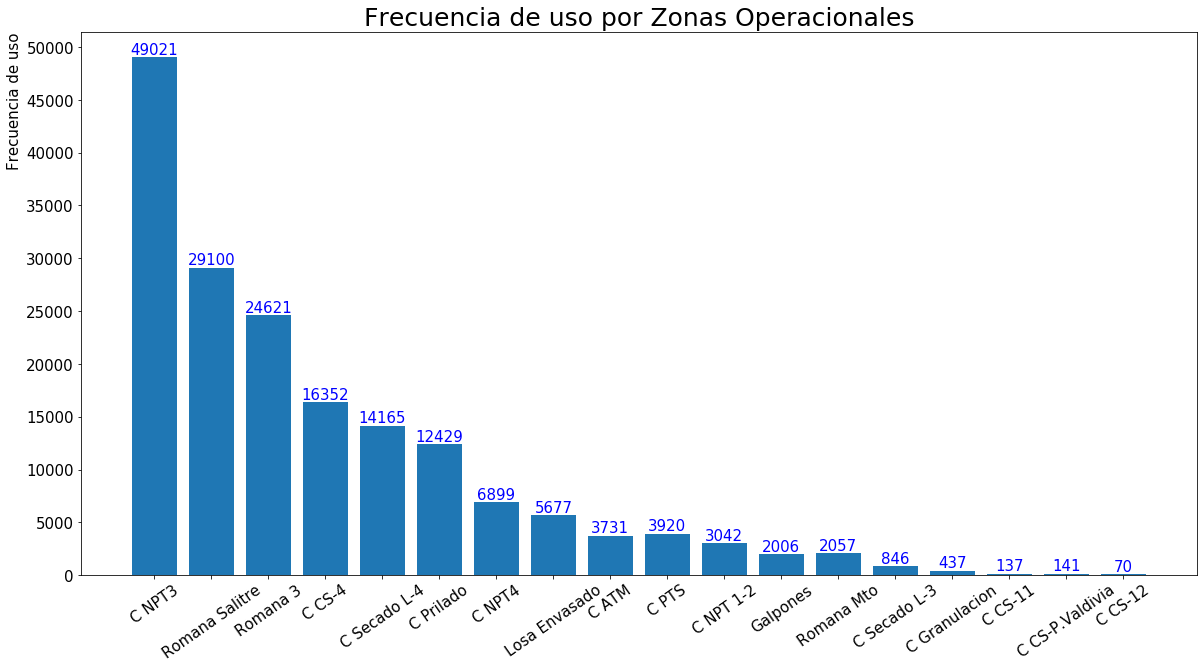

In [5]:
def frecuencia_uso(df,zonas):
    frecuencias_uso = []
    for zona in zonas:
        frecuencia = df[df['ZO']==zona].shape[0]
        frecuencias_uso.append(frecuencia)
    return frecuencias_uso

asd_1 = ['C NPT3' ,'Romana Salitre','Romana 3','C CS-4','C Secado L-4','C Prilado','C NPT4','Losa Envasado','C ATM','C PTS','C NPT 1-2','Galpones','Romana Mto','C Secado L-3','C Granulacion','C CS-11','C CS-P.Valdivia','C CS-12']
#asd_2 = [45554, 27292, 22766, 15832, 13393,11832,8129, 5275, 3448, 3345, 2934, 2013, 1840, 809,434,145,135, 67] 
asd_2 = frecuencia_uso(actividad,asd_1)

plt.figure(figsize=(20,10))
plt.bar(asd_1,asd_2)
plt.xticks(asd_1,rotation=35,fontsize=15)
plt.yticks(np.arange(0,50001,5000),fontsize=15)
plt.ylabel("Frecuencia de uso",fontsize=15,position=(1,1),ha='right')
plt.title("Frecuencia de uso por Zonas Operacionales",fontsize=25)
for index, value in enumerate(asd_2):
     plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom',position=(index,value+0.2))
#plt.savefig('./plot_finales/usos_zonas_operacionales.png')
plt.show()

---
# 2. Actividad promedio y peaks para canchas. (canchas y romanas por separado) #2


In [17]:
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,181],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
meses_del_año = dict(zip(meses, dias_mes)) 
zonas_sort = ['C NPT3' ,'Romana Salitre','Romana 3','C CS-4','C Secado L-4','C Prilado','C NPT4','Losa Envasado','C ATM',
                 'C PTS','C NPT 1-2','Galpones','Romana Mto','C Secado L-3','C Granulacion','C CS-11','C CS-P.Valdivia','C CS-12']
len(zonas)

18

In [8]:
metrica = ['max','mean']
for i in metrica:
    for mes in meses:
        print(mes, i)
        print(meses_del_año[mes][0],meses_del_año[mes][1])
        prom_act = analisis_por_dia(actividad,meses_del_año[mes][0],meses_del_año[mes][1],1,25,None,condicion='end',metric=i)
        prom_act.to_csv("./plot_finales/"+mes+"_"+i+"_out.csv")

Enero max
1 31
Febrero max
32 60
Marzo max
61 91
Abril max
92 121
Mayo max
122 152
Junio max
153 181
Julio max
182 212
Agosto max
213 243
Septiembre max
244 273
Octubre max
274 304
Noviembre max
305 334
Diciembre max
335 365
Enero mean
1 31
Febrero mean
32 60
Marzo mean
61 91
Abril mean
92 121
Mayo mean
122 152
Junio mean
153 181
Julio mean
182 212
Agosto mean
213 243
Septiembre mean
244 273
Octubre mean
274 304
Noviembre mean
305 334
Diciembre mean
335 365


In [19]:
max_1 = pd.read_csv('./plot_finales/actividad/max/Enero_max_out.csv').set_index(np.arange(1,25,1))
max_2 = pd.read_csv('./plot_finales/actividad/max/Febrero_max_out.csv').set_index(np.arange(1,25,1))
max_3 = pd.read_csv('./plot_finales/actividad/max/Marzo_max_out.csv').set_index(np.arange(1,25,1))
max_4 = pd.read_csv('./plot_finales/actividad/max/Abril_max_out.csv').set_index(np.arange(1,25,1))
max_5 = pd.read_csv('./plot_finales/actividad/max/Mayo_max_out.csv').set_index(np.arange(1,25,1))
max_6 = pd.read_csv('./plot_finales/actividad/max/Junio_max_out.csv').set_index(np.arange(1,25,1))
max_7 = pd.read_csv('./plot_finales/actividad/max/Julio_max_out.csv').set_index(np.arange(1,25,1))
max_8 = pd.read_csv('./plot_finales/actividad/max/Agosto_max_out.csv').set_index(np.arange(1,25,1))
max_9 = pd.read_csv('./plot_finales/actividad/max/Septiembre_max_out.csv').set_index(np.arange(1,25,1))
max_10 = pd.read_csv('./plot_finales/actividad/max/Octubre_max_out.csv').set_index(np.arange(1,25,1))
max_11 = pd.read_csv('./plot_finales/actividad/max/Noviembre_max_out.csv').set_index(np.arange(1,25,1))
max_12 = pd.read_csv('./plot_finales/actividad/max/Diciembre_max_out.csv').set_index(np.arange(1,25,1))


prom_1 = pd.read_csv('./plot_finales/actividad/mean/Enero_mean_out.csv').set_index(np.arange(1,25,1))
prom_2 = pd.read_csv('./plot_finales/actividad/mean/Febrero_mean_out.csv').set_index(np.arange(1,25,1))
prom_3 = pd.read_csv('./plot_finales/actividad/mean/Marzo_mean_out.csv').set_index(np.arange(1,25,1))
prom_4 = pd.read_csv('./plot_finales/actividad/mean/Abril_mean_out.csv').set_index(np.arange(1,25,1))
prom_5 = pd.read_csv('./plot_finales/actividad/mean/Mayo_mean_out.csv').set_index(np.arange(1,25,1))
prom_6 = pd.read_csv('./plot_finales/actividad/mean/Junio_mean_out.csv').set_index(np.arange(1,25,1))
prom_7 = pd.read_csv('./plot_finales/actividad/mean/Julio_mean_out.csv').set_index(np.arange(1,25,1))
prom_8 = pd.read_csv('./plot_finales/actividad/mean/Agosto_mean_out.csv').set_index(np.arange(1,25,1))
prom_9 = pd.read_csv('./plot_finales/actividad/mean/Septiembre_mean_out.csv').set_index(np.arange(1,25,1))
prom_10 = pd.read_csv('./plot_finales/actividad/mean/Octubre_mean_out.csv').set_index(np.arange(1,25,1))
prom_11 = pd.read_csv('./plot_finales/actividad/mean/Noviembre_mean_out.csv').set_index(np.arange(1,25,1))
prom_12 = pd.read_csv('./plot_finales/actividad/mean/Diciembre_mean_out.csv').set_index(np.arange(1,25,1))

max_total_2020 = (max_1.max()+max_2.max()+max_3.max()+max_4.max()+max_5.max()+max_6.max())/6
max_total = (max_1.max() +max_2.max()+max_3.max()+max_4.max()+max_5.max()+max_6.max()+
             max_7.max()+max_8.max()+max_9.max()+max_10.max()+max_11.max()+max_12.max())/12

prom_total_2020 = (prom_1.mean() +prom_2.mean()+prom_3.mean()+prom_4.mean()+prom_5.mean()+prom_6.mean())/6
prom_total_2020_2 = (prom_1.max() +prom_2.max()+prom_3.max()+prom_4.max()+prom_5.max()+prom_6.max())/6

prom_total = (prom_1.mean() +prom_2.mean()+prom_3.mean()+prom_4.mean()+prom_5.mean()+prom_6.mean()+
             prom_7.mean()+prom_8.mean()+prom_9.mean()+prom_10.mean()+prom_11.mean()+prom_12.mean())/12
prom_total_2 = (prom_1.max() +prom_2.max()+prom_3.max()+prom_4.max()+prom_5.max()+prom_6.max()+
             prom_7.max()+prom_8.max()+prom_9.max()+prom_10.max()+prom_11.max()+prom_12.max())/12

zonas = prom_2.columns.tolist()


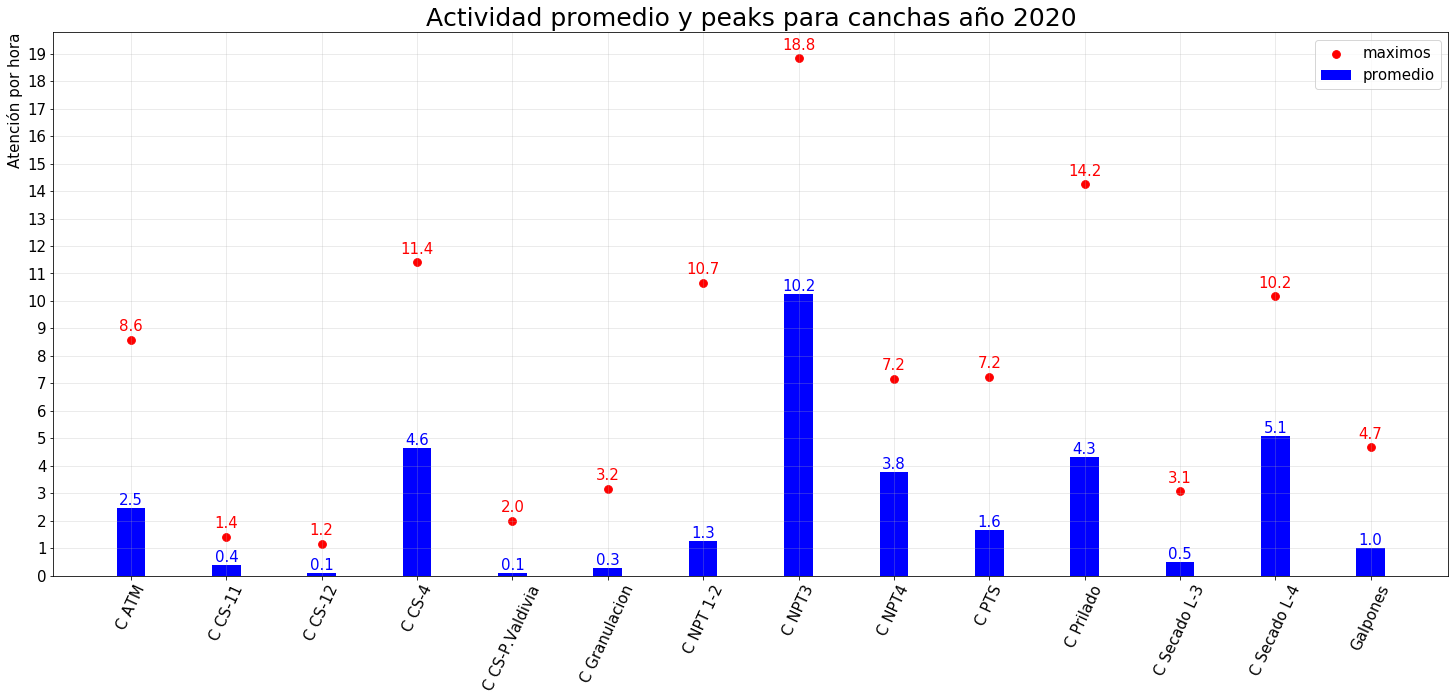

In [21]:
plt.figure(figsize=(25,10))
plt.scatter(zonas[1:15],max_total[1:15],c='r',s=60,label='maximos')
plt.bar(zonas[1:15],prom_total_2020_2[1:15],color='b',label='promedio',width=0.3)
plt.legend(fontsize=15)
plt.yticks(np.arange(0,20,1),fontsize=15)
plt.xticks(fontsize=15,rotation=65)
plt.grid(True,alpha=0.3)
for index, value in enumerate(prom_total_2020_2[1:15]):
    plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom')
for index, value in enumerate(max_total[1:15]):
    plt.text(index,value,str(round(value,1)),fontsize=15,color='r',ha='center',va='bottom',position=(index,value+0.2))
#plt.ylabel('Atención por hora',fontsize=25)
#plt.xlabel('Zonas', position=(1,1),ha='right',fontsize=15)
plt.ylabel('Atención por hora',position=(1,1),ha='right',fontsize=15)
plt.title("Actividad promedio y peaks para canchas año 2020",fontsize=25)
plt.savefig('./plot_finales/actividad/atencion_peak_prom_2020.png')
plt.show()

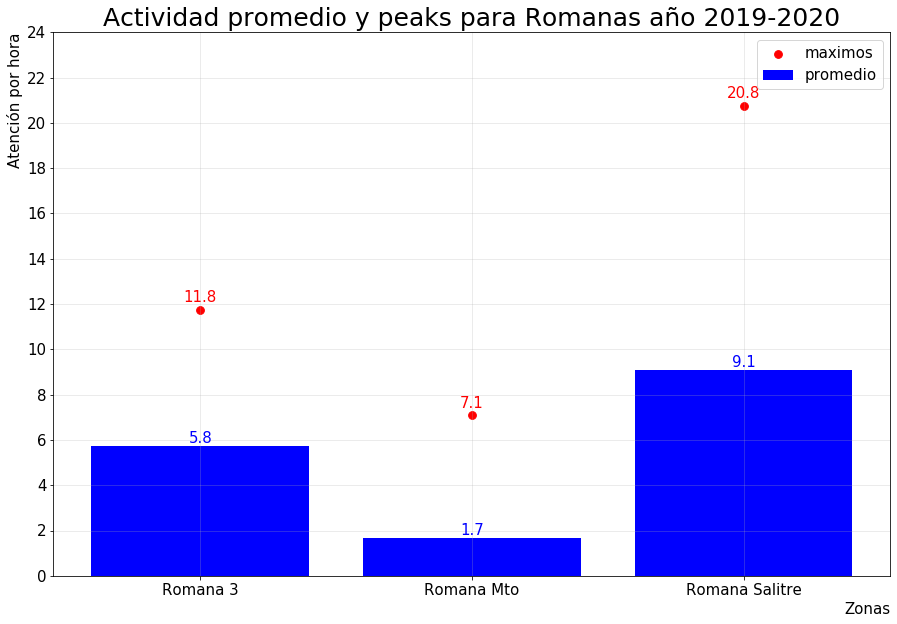

In [23]:
#Solo romanas
plt.figure(figsize=(15,10))
plt.scatter(zonas[16:19],max_total[16:19],c='r',s=60,label='maximos')
plt.bar(zonas[16:19],prom_total_2[16:19],color='b',label='promedio',width=0.8)
plt.legend(fontsize=15)
plt.yticks(np.arange(0,25,2),fontsize=15)
plt.xticks(fontsize=15,rotation=0)
plt.grid(True,alpha=0.3)
for index, value in enumerate(prom_total_2[16:19]):
    plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom')
for index, value in enumerate(max_total[16:19]):
    plt.text(index,value,str(round(value,1)),fontsize=15,color='r',ha='center',va='bottom',position=(index,value+0.2))
plt.xlabel('Zonas', position=(1,1),ha='right',fontsize=15)
plt.ylabel('Atención por hora',position=(1,1),ha='right',fontsize=15)
plt.title("Actividad promedio y peaks para Romanas año 2019-2020",fontsize=25)
plt.savefig('./plot_finales/actividad/atencion_peak_prom_romanas_2019_2020.png')
plt.show()

---
# 3. Actividad y llegada a espera de camiones por zona operacional. #18

__cambiar por el año completo__

In [37]:
metrica = ['max']
for mes in meses:
    print(mes)
    print(meses_del_año[mes][0],meses_del_año[mes][1])
#   prom_act = analisis_por_dia(colas,meses_del_año[mes][0],meses_del_año[mes][1],1,25,None,condicion='end',metric=i)
    cola_peak = analisis_por_dia(colas_old,meses_del_año[mes][0],meses_del_año[mes][1],1,25,None,condicion='end',metric='max')
    cola_peak.to_csv("./plot_finales/colas_"+mes+"_"+i+"_out.csv")

Enero
1 31
Febrero
32 60
Marzo
61 91
Abril
92 121
Mayo
122 152
Junio
153 181
Julio
182 212
Agosto
213 243
Septiembre
244 273
Octubre
274 304
Noviembre
305 334
Diciembre
335 365


In [60]:
peak_colas1 = pd.read_csv('./plot_finales/colas_peak/colas_Enero_max_out.csv').set_index(np.arange(1,25,1))
peak_colas2 = pd.read_csv('./plot_finales/colas_peak/colas_Febrero_max_out.csv').set_index(np.arange(1,25,1))
peak_colas3 = pd.read_csv('./plot_finales/colas_peak/colas_Marzo_max_out.csv').set_index(np.arange(1,25,1))
peak_colas4 = pd.read_csv('./plot_finales/colas_peak/colas_Abril_max_out.csv').set_index(np.arange(1,25,1))
peak_colas5 = pd.read_csv('./plot_finales/colas_peak/colas_Mayo_max_out.csv').set_index(np.arange(1,25,1))
peak_colas6 = pd.read_csv('./plot_finales/colas_peak/colas_Junio_max_out.csv').set_index(np.arange(1,25,1))
peak_colas7 = pd.read_csv('./plot_finales/colas_peak/colas_Julio_max_out.csv').set_index(np.arange(1,25,1))
peak_colas8 = pd.read_csv('./plot_finales/colas_peak/colas_Agosto_max_out.csv').set_index(np.arange(1,25,1))
peak_colas9 = pd.read_csv('./plot_finales/colas_peak/colas_Septiembre_max_out.csv').set_index(np.arange(1,25,1))
peak_colas10 = pd.read_csv('./plot_finales/colas_peak/colas_Octubre_max_out.csv').set_index(np.arange(1,25,1))
peak_colas11 = pd.read_csv('./plot_finales/colas_peak/colas_Noviembre_max_out.csv').set_index(np.arange(1,25,1))
peak_colas12 = pd.read_csv('./plot_finales/colas_peak/colas_Diciembre_max_out.csv').set_index(np.arange(1,25,1))

cola_max_2020 = (peak_colas1+peak_colas2+peak_colas3+peak_colas4+peak_colas5+peak_colas6)/6
cola_max = (peak_colas1 +peak_colas2+peak_colas3+peak_colas4+peak_colas5+peak_colas6+
             peak_colas7+peak_colas8+peak_colas9+peak_colas10+peak_colas11+peak_colas12)/12

actividad_max_2020 = (max_1+max_2+max_3+max_4+max_5+max_6)/6
actividad_max = (max_1 +max_2+max_3+max_4+max_5+max_6+
             max_7+max_8+max_9+max_10+max_11+max_12)/12

In [38]:
# peaks_cola_2020 = analisis_por_dia(colas_old,1,160,1,25,None,condicion='end',metric='max')
# peaks_act_2020 = analisis_por_dia(actividad,1,160,1,25,None,condicion='end',metric='max')
# peaks_cola = analisis_por_dia(colas_old,1,365,1,25,None,condicion='end',metric='max')
# peaks_act = analisis_por_dia(actividad,1,365,1,25,None,condicion='end',metric='max')

# peaks_cola_2020.to_csv("./plot_finales/colas_2020_out.csv")
# peaks_act_2020.to_csv("./plot_finales/actividad_2020_out.csv")
# peaks_cola.to_csv("./plot_finales/colas_2019_2020_out.csv")
# peaks_act.to_csv("./plot_finales/actividad_2019_2020_out.csv")

peaks_cola_2020 = pd.read_csv("./plot_finales/colas_2020_out.csv")
peaks_act_2020 = pd.read_csv("./plot_finales/actividad_2020_out.csv")
peaks_cola = pd.read_csv("./plot_finales/colas_2019_2020_out.csv")
peaks_act = pd.read_csv("./plot_finales/actividad_2019_2020_out.csv")

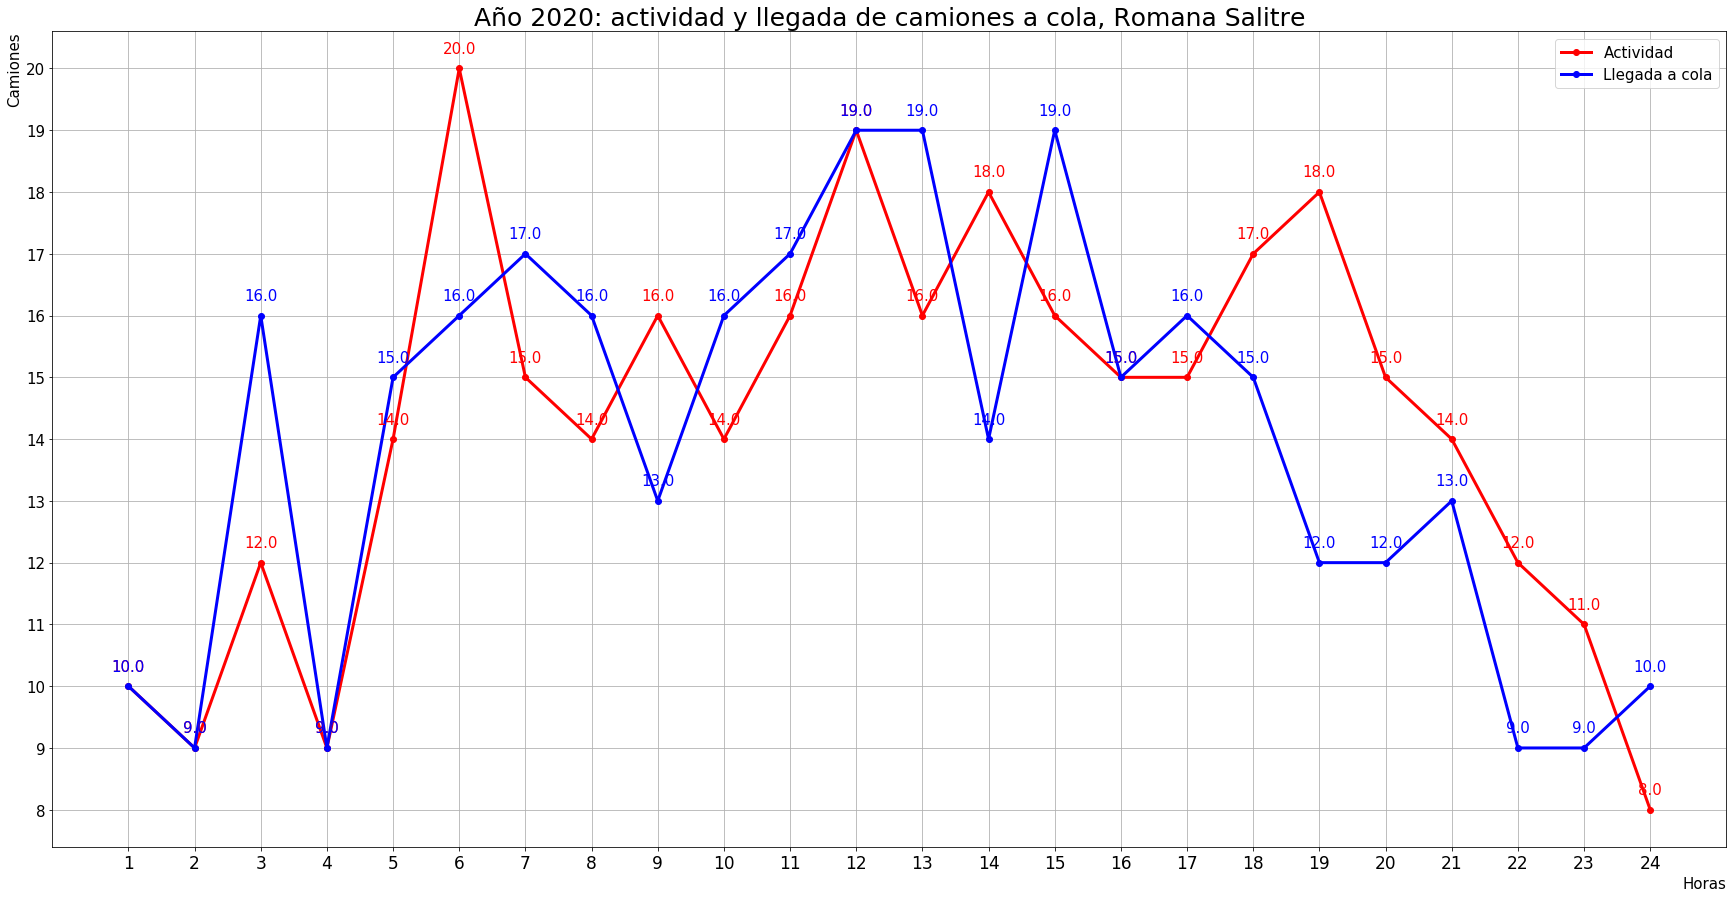

In [55]:
"""ESTOS GRAFICOS DE ACA SON LOS MISMOS DE LAS PRESENTACIONES, tomamos el peak más alto para cada horario durante el 2020"""
for zona in zonas[1:]:
    maximo = int(max(peaks_act_2020[zona].max(),peaks_cola_2020[zona].max()))
    minimo = int(min(peaks_act_2020[zona].min(),peaks_cola_2020[zona].min()))
    steps = round((((maximo-minimo)+1)/10),0)
    if steps ==0:
        steps = 0.2
    plt.figure(figsize=(30,15))
    plt.plot(peaks_act_2020[zona],'ro-',lw=3,label='Actividad')
    plt.plot(peaks_cola_2020[zona],'bo-',lw=3,label='Llegada a cola')
    plt.title("Año 2020: actividad y llegada de camiones a cola, "+zona,fontsize=25)
    plt.xlabel('Horas', position=(1,1),ha='right',fontsize=15)
    plt.ylabel('Camiones',position=(1,1),ha='right',fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=17)
    plt.yticks(np.arange(minimo,maximo+1,steps),fontsize=15)
    for index, value in enumerate(peaks_act_2020[zona]):
        plt.text(index,value,str(round(value,1)),fontsize=15,color='r',ha='center',va='bottom',position=(index+1,value+0.2))
    for index, value in enumerate(peaks_cola_2020[zona]):
        plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom',position=(index+1,value+0.2))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.savefig("./plot_finales/actividad_llegada_a_cola/v1/2020/actividad_cola_2020_max_"+zona+"_v1.png")
    plt.show()
    clear_output(wait=True)

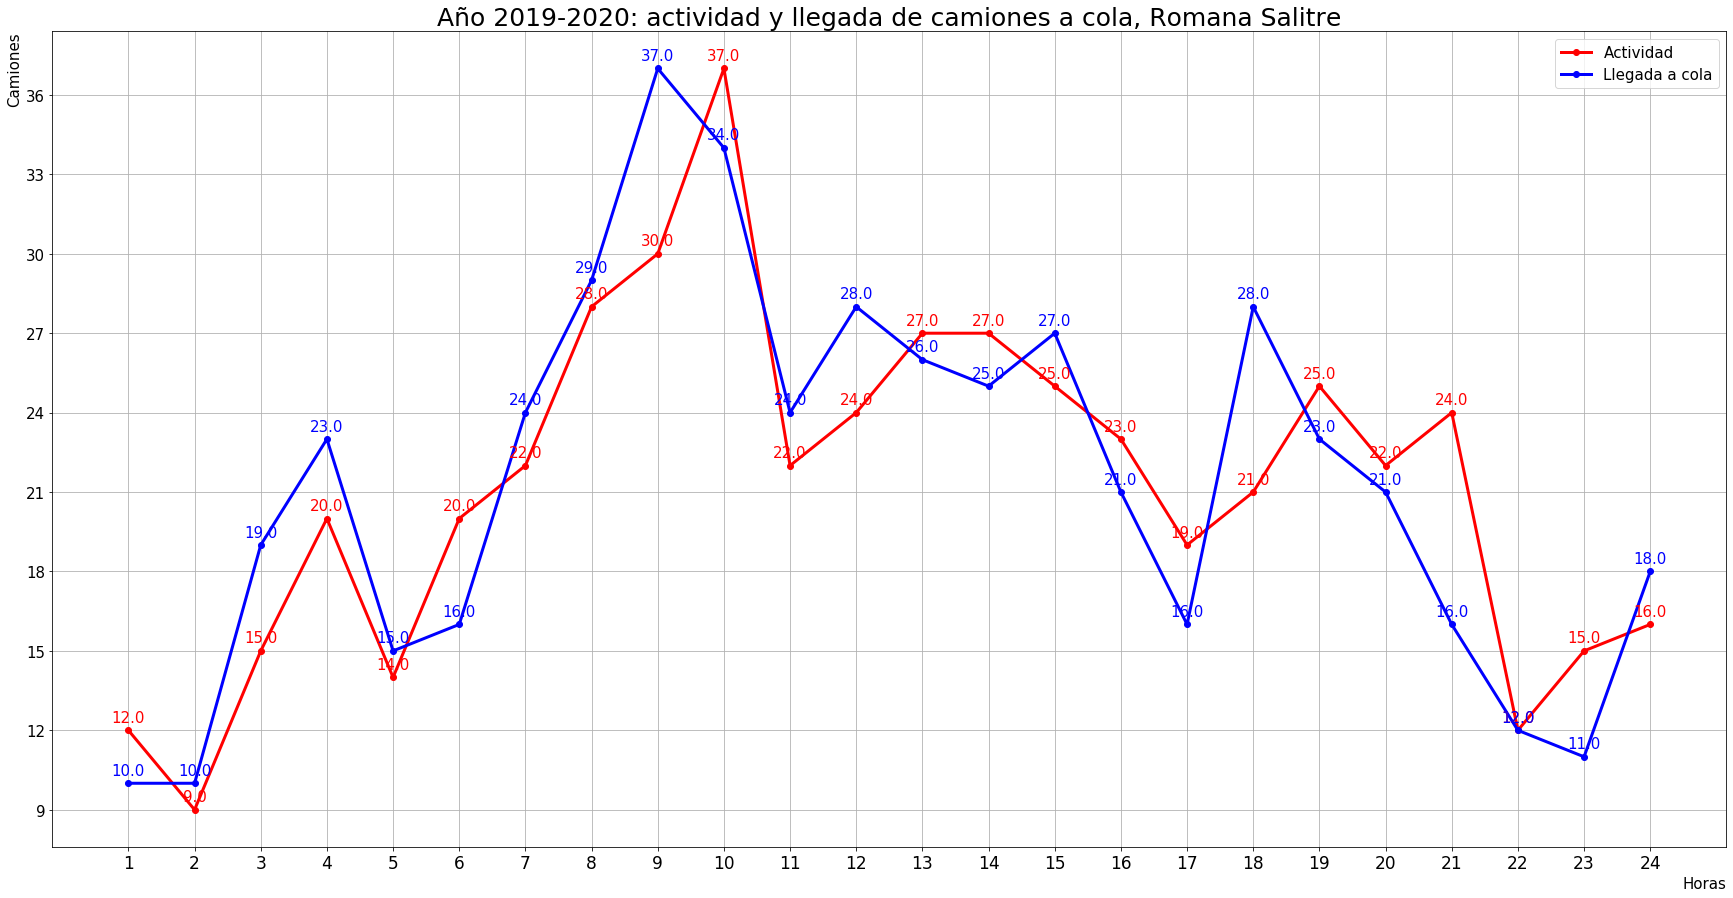

In [63]:
"""ESTOS GRAFICOS DE ACA SON LOS MISMOS DE LAS PRESENTACIONES, tomamos el peak más alto para cada horario durante el 2019-2020"""
for zona in zonas[1:]:
    maximo = int(max(peaks_act[zona].max(),peaks_cola[zona].max()))
    minimo = int(min(peaks_act[zona].min(),peaks_cola[zona].min()))
    steps = round((((maximo-minimo)+1)/10),0)
    if steps ==0:
        steps = 0.2
    plt.figure(figsize=(30,15))
    plt.plot(peaks_act[zona],'ro-',lw=3,label='Actividad')
    plt.plot(peaks_cola[zona],'bo-',lw=3,label='Llegada a cola')
    plt.title("Año 2019-2020: actividad y llegada de camiones a cola, "+zona,fontsize=25)
    plt.xlabel('Horas', position=(1,1),ha='right',fontsize=15)
    plt.ylabel('Camiones',position=(1,1),ha='right',fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=17)
    plt.yticks(np.arange(minimo,maximo+1,steps),fontsize=15)
    for index, value in enumerate(peaks_act[zona]):
        plt.text(index,value,str(round(value,1)),fontsize=15,color='r',ha='center',va='bottom',position=(index+1,value+0.2))
    for index, value in enumerate(peaks_cola[zona]):
        plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom',position=(index+1,value+0.2))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.savefig("./plot_finales/actividad_llegada_a_cola/v1/2019_2020/actividad_cola_max_"+zona+"_v1.png")
    plt.show()
    clear_output(wait=True)

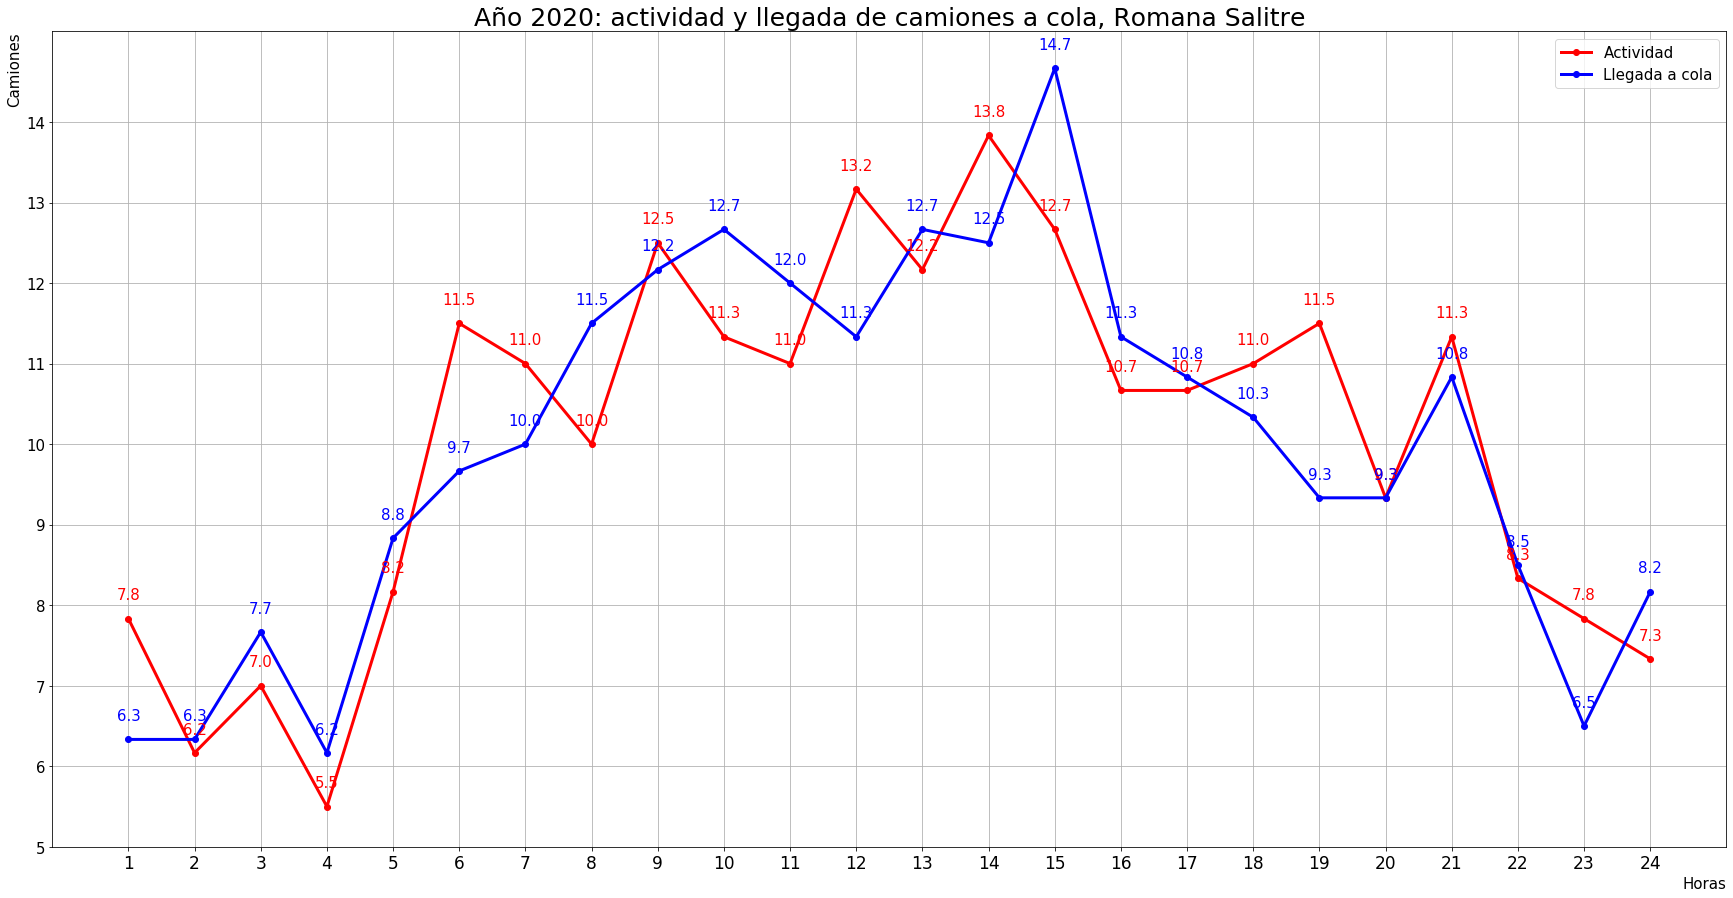

In [62]:
"""ESTOS GRAFICOS DE ACA SON distintos a los de las  PRESENTACIONES,
   tomamos el peak más alto de cada mes y se promedian los meses durante el 2020, este es mas representativo con el gráfico de actividad que hemos tomado"""

for zona in zonas[1:]:
    maximo = int(max(actividad_max_2020[zona].max(),cola_max_2020[zona].max()))
    minimo = int(min(actividad_max_2020[zona].min(),cola_max_2020[zona].min()))
    steps = round((((maximo-minimo)+1)/10),0)
    if steps ==0:
        steps = 0.2
    plt.figure(figsize=(30,15))
    plt.plot(actividad_max_2020[zona],'ro-',lw=3,label='Actividad')
    plt.plot(cola_max_2020[zona],'bo-',lw=3,label='Llegada a cola')
    plt.title("Año 2020: actividad y llegada de camiones a cola, "+zona,fontsize=25)
    plt.xlabel('Horas', position=(1,1),ha='right',fontsize=15)
    plt.ylabel('Camiones',position=(1,1),ha='right',fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=17)
    plt.yticks(np.arange(minimo,maximo+1,steps),fontsize=15)
    for index, value in enumerate(actividad_max_2020[zona]):
        plt.text(index,value,str(round(value,1)),fontsize=15,color='r',ha='center',va='bottom',position=(index+1,value+0.2))
    for index, value in enumerate(cola_max_2020[zona]):
        plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom',position=(index+1,value+0.2))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.savefig("./plot_finales/actividad_llegada_a_cola/v2/2020/actividad_cola_2020_max_"+zona+"_v2.png")
    plt.show()
    clear_output(wait=True)

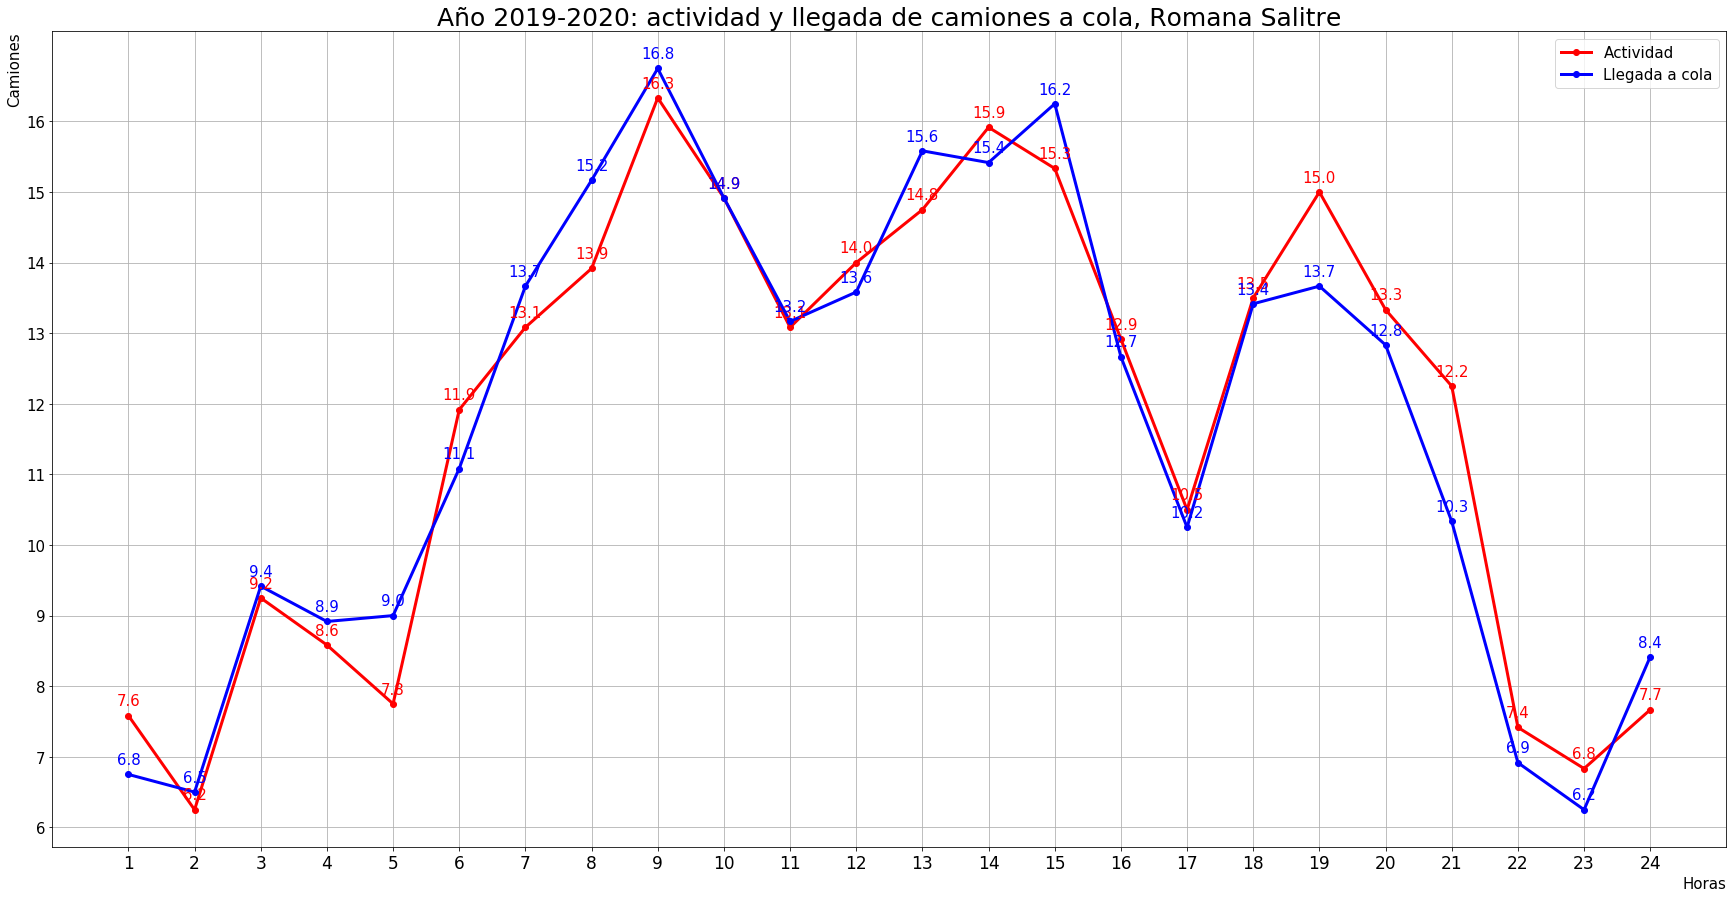

In [66]:
"""ESTOS GRAFICOS DE ACA SON distintos a los de las  PRESENTACIONES,
   tomamos el peak más alto de cada mes y se promedian los meses durante el 2019-2020, este es mas representativo con el gráfico de actividad que hemos tomado"""

for zona in zonas[1:]:
    maximo = int(max(actividad_max[zona].max(),cola_max[zona].max()))
    minimo = int(min(actividad_max[zona].min(),cola_max[zona].min()))
    steps = round((((maximo-minimo)+1)/10),0)
    if steps ==0:
        steps = 0.2
    plt.figure(figsize=(30,15))
    plt.plot(actividad_max[zona],'ro-',lw=3,label='Actividad')
    plt.plot(cola_max[zona],'bo-',lw=3,label='Llegada a cola')
    plt.title("Año 2019-2020: actividad y llegada de camiones a cola, "+zona,fontsize=25)
    plt.xlabel('Horas', position=(1,1),ha='right',fontsize=15)
    plt.ylabel('Camiones',position=(1,1),ha='right',fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=17)
    plt.yticks(np.arange(minimo,maximo+1,steps),fontsize=15)
    for index, value in enumerate(actividad_max[zona]):
        plt.text(index,value,str(round(value,1)),fontsize=15,color='r',ha='center',va='bottom',position=(index+1,value+0.1))
    for index, value in enumerate(cola_max[zona]):
        plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom',position=(index+1,value+0.1))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.savefig("./plot_finales/actividad_llegada_a_cola/v2/2019_2020/actividad_cola_max_"+zona+"_v2.png")
    plt.show()
    clear_output(wait=True)

---
# 4. Análisis colas, minutos en cola, por zona operacional. #18

In [124]:
def stack_by_day_2(df,zone,dia_inicial,dia_final,metric='max',name=None,origen=None):
    "Nos entrega el análisis por una cantidad X de dias, toma los días del año"
    count = 0
    df_final = None
    if (origen != None):
        df = df[df['Origin'] == origen]
    for i in range(dia_inicial,dia_final+1):
        #print(i)
        aux,_ = convert_df_to_df(df,zone,i)
        if count == 0:
            df_final = aux
            count += 1
        else:
            if (metric == 'max'):
                df_final = pd.concat([df_final, aux]).max(level=0)   #Aquí indico que necesito los peaks
            elif (metric == 'mean'):
                df_final = pd.concat([df_final,aux]).mean(level=0)
    if name != None:
        df_final.sort_index(axis=0).to_csv(name,index=False)
    return df_final.sort_index(axis=0)

def plot_minutos_totales2(df,title,file=None):    
    min1 = int(df['minutos/camion'].min())
    min2 = int(df['minutos'].min())
    max1 = int(df['minutos/camion'].max()+5)
    max2 = int(df['minutos'].max()+5)
    gap =  int((max1-min1)/15)
    gap_2= int((max2-min2)/15)
    if gap_2 == 0:
        gap_2 = 1
    if gap == 0:
        gap = 1

    fig, ax = plt.subplots(figsize=(20,10))
    plt.title(title,fontsize=25)
    plt.grid(True,alpha=0.4)

    ax.set_xlabel('Horas',position=(1,1),ha='right',fontsize=15)
    ax.set_ylabel('Min/camion',position=(1,1),ha='right',fontsize=15, color='black')
    line1 = ax.plot(df['block'], df['minutos/camion'],marker='o',linestyle='-',lw=3, color='red',label='min/truck')
    line3 = ax.bar(df['block'],df['camiones'],width=0.5, color='blue',align='center')
    for index, value in enumerate(df['minutos/camion']):
        plt.text(index,value,str(int(value)),fontsize=15,color='red',ha='center',va='bottom',position=(index+1,value+0.2))
    for index, value in enumerate(df['camiones']):
        plt.text(index,value,str(int(value)),fontsize=15,color='red',ha='center',va='bottom',position=(index+1,value+0.2))

    ax.legend(["trucks"],loc='upper left')
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticks(np.arange(1,25,1))
    ax.set_xticklabels(np.arange(1,25,1),fontsize=15)
    ax.set_yticks(np.arange(0,max1,gap))
    ax.set_yticklabels(np.arange(0,max1,gap),fontsize=15)
    #plt.xlabel('Zonas', position=(1,1),ha='right',fontsize=15)
    #plt.ylabel('Atención por hora',position=(1,1),ha='right',fontsize=15)
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Minutos', position=(1,1),ha='right',fontsize=15, color='black')  # we already handled the x-label with ax1
    line2 = ax2.plot(df['block'],df['minutos'],marker='o',linestyle='--',lw=3,color='green',label='Minutos totales')
    
    ax2.tick_params(axis='y', labelcolor='green')
    print(gap_2,max2)
    ax2.set_yticks(np.arange(0,max2,gap_2))
    ax2.set_yticklabels(np.arange(0,max2,gap_2),fontsize=15)
    ax2.fill_between(df['block'],df['minutos'],alpha=0.3)
    for index, value in enumerate(df['minutos']):
        plt.text(index,value,str(int(value)),fontsize=15,color='green',ha='center',va='bottom',position=(index+1,value+0.2))

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # added these two lines
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    #print(lns)
    ax.legend(lns, labs, loc=0,fontsize=20)
    if file != None: 
        plt.savefig(file)
    plt.show()
    plt.close()

def plot_minutos_totales(df,title,file=None,gap=10,gap_2=1):    
    min1 = int(df['minutos/camion'].min())
    min2 = int(df['minutos'].min())
    max1 = int(df['minutos/camion'].max()+5)
    max2 = int(df['minutos'].max()+5)

    fig, ax = plt.subplots(figsize=(20,10))
    plt.title(title,fontsize=25)
    plt.grid(True,alpha=0.4)

    ax.set_xlabel('Horas',fontsize=20)
    ax.set_ylabel('Min/camion',fontsize=20, color='black')
    line1 = ax.plot(df['block'], df['minutos/camion'],marker='o',linestyle='-',lw=3, color='red',label='min/truck')
    line3 = ax.bar(df['block'],df['camiones'],width=0.5, color='blue',align='center')
    ax.legend(["trucks"],loc='upper left')
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticks(np.arange(1,25,1))
    ax.set_xticklabels(np.arange(1,25,1),fontsize=15)
    ax.set_yticks(np.arange(0,max1,gap_2))
    ax.set_yticklabels(np.arange(0,max1,gap_2),fontsize=15)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Minutos', fontsize=20, color='black')  # we already handled the x-label with ax1
    line2 = ax2.plot(df['block'],df['minutos'],marker='o',linestyle='--',lw=3,color='green',label='Minutos totales')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_yticks(np.arange(0,max2,gap))
    ax2.set_yticklabels(np.arange(0,max2,gap),fontsize=15)
    ax2.fill_between(df['block'],df['minutos'],alpha=0.3)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # added these two lines
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    #print(lns)
    ax.legend(lns, labs, loc=0,fontsize=20)
    if file != None: 
        plt.savefig(file)
    plt.show()
def plot_minutos_cola_fail(df,title,file=None,gap_1=10,gap_2=1,up_1=1,low_1=1,up_2=1,low_2=1):    
    min1 = int(df['minutos/camion'].min())
    min2 = int(df['minutos'].min())
    max1 = int(df['minutos/camion'].max()+5)
    max2 = int(df['minutos'].max()+5)

    fig, ax = plt.subplots(figsize=(20,10))
    plt.title(title,fontsize=25)
    plt.grid(True,alpha=0.4)

    ax.set_xlabel('Horas',fontsize=20)
    ax.set_ylabel('Min/camion',fontsize=20, color='black')
    line1 = ax.plot(df['block'], df['minutos/camion'],marker='o',linestyle='-',lw=3, color='red',label='min/truck')
    line3 = ax.bar(df['block'],df['camiones'],width=0.5, color='blue',align='center')
    ax.legend(["trucks"],loc='upper left')
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticks(np.arange(1,25,1))
    ax.set_xticklabels(np.arange(1,25,1),fontsize=15)
    ax.set_yticks(np.arange(low_1,up_1,gap_1))
    ax.set_yticklabels(np.arange(low_1,up_1,gap_1),fontsize=15)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Minutos', fontsize=20, color='black')  # we already handled the x-label with ax1
    line2 = ax2.plot(df['block'],df['minutos'],marker='o',linestyle='--',lw=3,color='green',label='Minutos totales')
    ax2.tick_params(axis='y', labelcolor='green')
    asd = [0.0,0.1,0.2,0.3,0.4]
    ax2.set_yticks(asd)
    ax2.set_yticklabels(asd,fontsize=15)
    ax2.fill_between(df['block'],df['minutos'],alpha=0.3)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # added these two lines
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    #print(lns)
    ax.legend(lns, labs, loc=0,fontsize=20)
    if file != None: 
        plt.savefig(file)
    plt.show()

Romana Salitre Enero
Romana Salitre Febrero
Romana Salitre Marzo
Romana Salitre Abril
Romana Salitre Mayo
Romana Salitre Junio
Romana Salitre Julio
Romana Salitre Agosto
Romana Salitre Septiembre
Romana Salitre Octubre
Romana Salitre Noviembre
Romana Salitre Diciembre
6 96


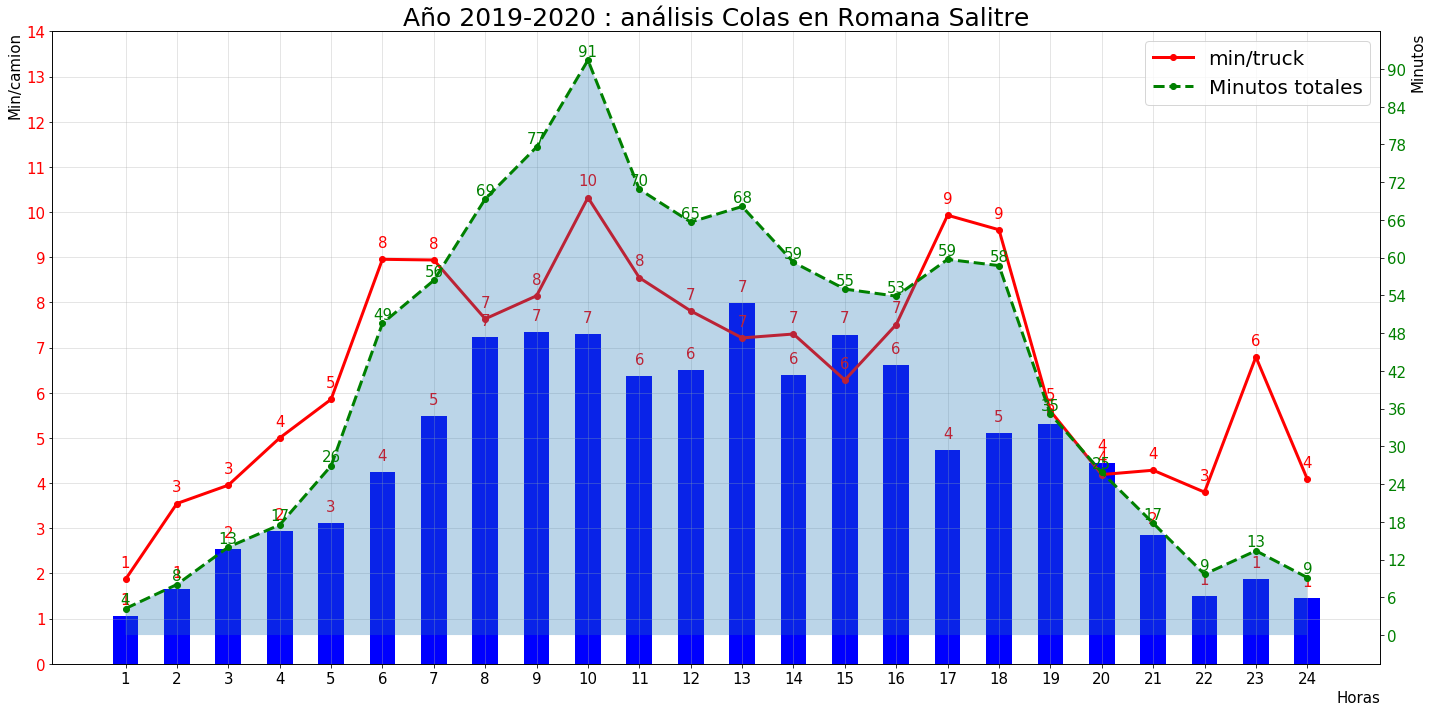

In [89]:
#creamos todos los plots necesarios para el promedio.
meses_2020 = ['Enero','Febrero','Marzo','Abril','Mayo','Junio']
meses_2019 = ['Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
romanas = ['Romana 3','Romana Mto','Romana Salitre']

###plots 2019-2020
for zona in zonas[1:]:
    df_zona = None
    count = 1
    for mes in meses:
        print(zona,mes)
        #print(meses_del_año[mes][0],meses_del_año[mes][1])
        b_1 = stack_by_day_2(colas,zona,meses_del_año[mes][0],meses_del_año[mes][1],metric='mean')
        b_1['minutos'] = b_1['minutos/camion']*b_1['camiones']
#        print(b_1)
#       title = mes + " : analisis Colas en cancha " + zona
#         file = "./colas_finales/" + mes + "/colas_minutos_" + mes + "_" + zona + ".png"
#         #plot_minutos_totales(b_1,title,file=None)
#         #clear_output(wait=True)
        #print(b_1)
        if count==1:
            df_zona =  b_1
            count+=1
        else:
            df_zona = df_zona + b_1
            count+=1
    df_zona = df_zona/(count-1)
    title = "Año 2019-2020 : análisis Colas en " + zona
    file = "./plot_finales/minutos_cola/2019_2020/colas_minutos_" + zona + "_v2.png"
    plot_minutos_totales2(df_zona,title,file)
    clear_output(wait=True)

Romana Salitre Enero
1 31
Romana Salitre Febrero
32 60
Romana Salitre Marzo
61 91
Romana Salitre Abril
92 121
Romana Salitre Mayo
122 152
Romana Salitre Junio
153 181


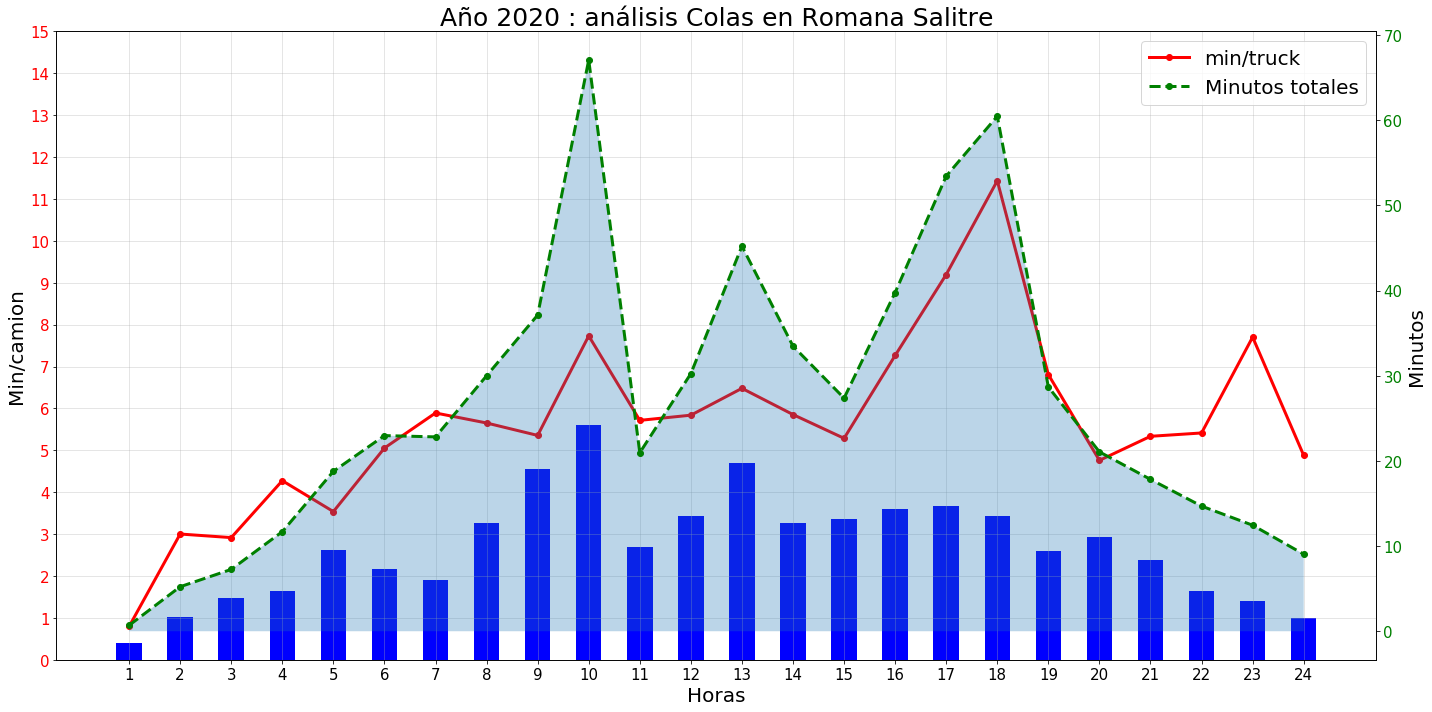

In [93]:
###plots 2020
for zona in zonas[1:]:
    df_zona = None
    count = 1
    for mes in meses_2020:
        print(zona,mes)
        print(meses_del_año[mes][0],meses_del_año[mes][1])
        b_1 = stack_by_day_2(colas,zona,meses_del_año[mes][0],meses_del_año[mes][1],metric='mean')
        b_1['minutos'] = b_1['minutos/camion']*b_1['camiones']
#        print(b_1)
#       title = mes + " : analisis Colas en cancha " + zona
#         file = "./colas_finales/" + mes + "/colas_minutos_" + mes + "_" + zona + ".png"
#         #plot_minutos_totales(b_1,title,file=None)
#         #clear_output(wait=True)
        #print(b_1)
        if count==1:
            df_zona =  b_1
            count+=1
        else:
            df_zona = df_zona + b_1
            count+=1
    df_zona = df_zona/(count-1)
    title = "Año 2020 : análisis Colas en " + zona
    file = "./plot_finales/minutos_cola/2020/colas_minutos_" + zona + "_v1.png"
    plot_minutos_totales(df_zona,title,file)
    clear_output(wait=True)


In [126]:
# zonas_fail = ['C CS-12','C CS-P.Valdivia']
# for zona in zonas_fail:
#     df_zona = None
#     count = 1
#     for mes in meses_2020:
#         print(zona,mes)
#         print(meses_del_año[mes][0],meses_del_año[mes][1])
#         b_1 = stack_by_day_2(colas,zona,meses_del_año[mes][0],meses_del_año[mes][1],metric='mean')
#         b_1['minutos'] = b_1['minutos/camion']*b_1['camiones']
#         if count==1:
#             df_zona =  b_1
#             count+=1
#         else:
#             df_zona = df_zona + b_1
#             count+=1
#     df_zona = df_zona/(count-1)
#     title = "Año 2020 : análisis Colas en " + zona
#     file = "./plot_finales/minutos_cola/2020/colas_minutos_" + zona + "_v1.png"
#     plot_minutos_cola_fail(df_zona,title,file,gap_1=0.5,gap_2=0.100,up_1=2.5,low_1=0,up_2=0.41,low_2=0)
#     clear_output(wait=True)

---
# 5-6-7. Tiempos máximos, Horas y Costo perdido por ZO. #1

In [183]:
def monetizacion(df,df_,zona,dia,fin=None,tiempo_ideal=None,zonas=None):
    """Entrega las horas perdidas, camiones perdidos y dinero max y min perdido para un
    determinado tiempo y zona operacional"""
    #Parametros
    toneladas = 29.5
    price_min = 9500 
    price_max = 13000
    hr_job = 16    
    if fin == None:
        fin = dia
    for i in range(dia,fin+1): 
        prom_cola = analisis_por_dia_2(df,i,i,1,25,None,condicion='end',metric='mean',zonas=zonas)
        a = stack_by_day(df_,zona,i,i,metric='mean')
        a['minutos'] = a['minutos/camion']*a['camiones']

        #calculo de dif_time
        dif_time = pd.concat([a[['block','minutos']],prom_cola[zona]],axis=1)
        dif_time["diferencia"] = dif_time['minutos']- dif_time[zona]*tiempo_ideal
        dif_time.loc[dif_time['diferencia'] < 0, 'diferencia'] = 0   

        #MONETIZACIÓN
        horas = (dif_time['diferencia'].sum())/60.  #horas perdidas por dia
        camiones = horas/hr_job                     #turnos camion perdidos
        precio_minimo = (camiones * toneladas * price_min)/1000000.
        precio_maximo = (camiones * toneladas * price_max)/1000000.

        if i == dia:
            atributos = [horas,camiones,precio_minimo,precio_maximo]
        else:
            atributos = [horas+atributos[0],camiones+atributos[1],precio_minimo+atributos[2],precio_maximo+atributos[3]]
    return atributos

def found_time_zona(zona):
    aux = actividad[~((actividad['Origin'] == 'Coya Sur') & (actividad['Destination'] == 'Coya Sur'))]
    if zona == 'C Granulacion':
        df_aux = aux[(aux['time Act']<= 1500) & (aux['ZO'] == zona) ]
    else:
        df_aux = aux[aux['ZO'] == zona]

    tiempo_hacia_zo = 8  # 6 minutos promedio a cada zo
    a = df_aux[(df_aux['Pre Time'] <= 1500)].describe() #filtro por tiempo menor a 25 minutos
    #a = df_aux.describe() 
    #print(a)
    actividad_zo = round(a.iloc[5,3]/60,1)
    #print(actividad_zo)
    if actividad_zo > 12:
        tiempo_real = tiempo_hacia_zo + (1*round(actividad_zo,1))+6    
    else:    
        tiempo_real = tiempo_hacia_zo + (3*round(actividad_zo,1))+6
    return [zona,round(tiempo_real,1)]


def found_time_romanas(trayecto=None):
    df_aux = actividad[~((actividad['Origin'] == 'Coya Sur') & (actividad['Destination'] == 'Coya Sur'))]
    romanas = ['Romana Salitre','Romana Mto','Romana 3']
    romanas_values = []
    for romana in romanas:
        aux_2 = df_aux[df_aux['ZO'] == romana]
        #A la 1era ZO.
        #print("Trayectos",aux_2.Origin.unique())
        a = aux_2[(aux_2['Pre Time'] <= 1500) & (aux_2['time start'] <= datetime.time(3,0,0))].describe()
        #a = aux_2.describe()
        tiempo_real = round(a.iloc[5,0]/60,1) + (round(a.iloc[5,3]/60,1))+6
        #print("pre time: ",round(a.iloc[5,0]/60,1))
        #print("act: ",(round(a.iloc[5,3]/60,1)))
        print("El tiempo a utilizar para  " + romana +" será: ", tiempo_real, " minutos")
        romanas_values.append([romana,tiempo_real])
    return romanas_values

In [184]:
zonas = ['C Secado L-3','C NPT3','C Prilado','C ATM','Losa Envasado','Galpones','C NPT4',
         'C CS-11','C CS-12','C PTS','C Secado L-4','C CS-P.Valdivia','C CS-4','C NPT 1-2','C Granulacion']
pesos_zonas = []
for zona in zonas:
    a = found_time_zona(zona)
    pesos_zonas.append(a)
    print("El timepo a utilizar para "+a[0]+" sera: ",a[1], " minutos")

b = found_time_romanas()
for i in b:
    pesos_zonas.append(i)
pesos =  pd.DataFrame(pesos_zonas,columns=['zonas','pesos']).sort_values('pesos',ascending=False)

El timepo a utilizar para C Secado L-3 sera:  44.0  minutos
El timepo a utilizar para C NPT3 sera:  32.3  minutos
El timepo a utilizar para C Prilado sera:  26.4  minutos
El timepo a utilizar para C ATM sera:  28.1  minutos
El timepo a utilizar para Losa Envasado sera:  30.8  minutos
El timepo a utilizar para Galpones sera:  28.7  minutos
El timepo a utilizar para C NPT4 sera:  29.0  minutos
El timepo a utilizar para C CS-11 sera:  41.9  minutos
El timepo a utilizar para C CS-12 sera:  23.0  minutos
El timepo a utilizar para C PTS sera:  32.6  minutos
El timepo a utilizar para C Secado L-4 sera:  36.5  minutos
El timepo a utilizar para C CS-P.Valdivia sera:  31.7  minutos
El timepo a utilizar para C CS-4 sera:  36.8  minutos
El timepo a utilizar para C NPT 1-2 sera:  36.2  minutos
El timepo a utilizar para C Granulacion sera:  47.0  minutos
El tiempo a utilizar para  Romana Salitre será:  20.2  minutos
El tiempo a utilizar para  Romana Mto será:  17.4  minutos
El tiempo a utilizar para

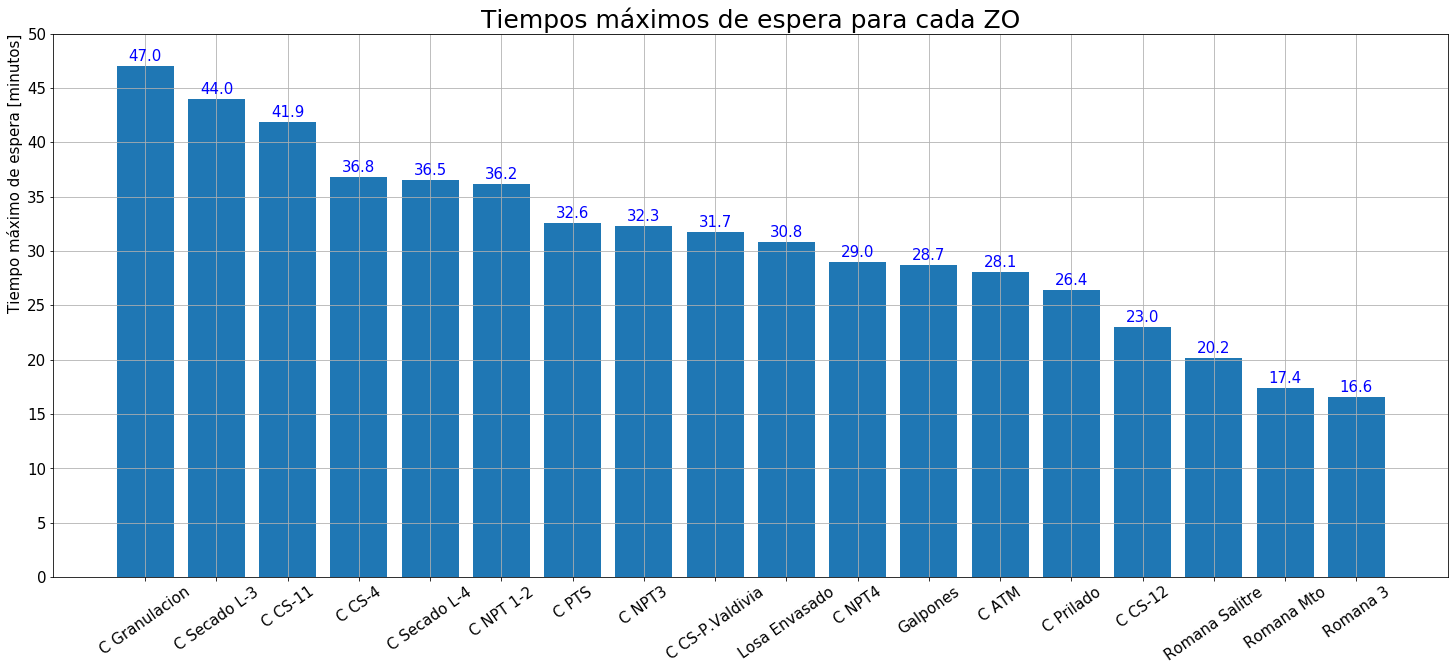

In [186]:
plt.figure(figsize=(25,10))
plt.bar(pesos['zonas'],pesos['pesos'])
plt.ylabel("Tiempo máximo de espera [minutos]",position=(1,1),ha='right',fontsize=15)
plt.title("Tiempos máximos de espera para cada ZO",fontsize=25)
plt.xticks(pesos['zonas'],fontsize=15,rotation=35)
plt.yticks(np.arange(0,51,5),fontsize=15)
for index, value in enumerate(pesos['pesos']):
     plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom',position=(index,value+0.2))
plt.grid(True)
plt.savefig('./plot_finales/pesos_por_zona.png')
plt.show()

In [189]:
def analisis_por_dia_2(df,dia_inicial,dia_final,hora_incial=1,hora_final=25,name=None,condicion='end',metric='max',zonas=None):
    "Nos entrega el análisis por una cantidad X de dias, toma los días del año"
    count = 0
    df_final = None
    for i in range(dia_inicial,dia_final+1):
        #print(i)
        aux = dict_to_df_2(vehiculos_cola(df,i,i,1,25,condicion),zonas)
        if count == 0:
            df_final = aux
            count += 1
        else:
            if (metric == 'max'):
                df_final = pd.concat([df_final, aux]).max(level=0)   #Aquí indico que necesito los peaks
            elif (metric == 'mean'):
                df_final = pd.concat([df_final,aux]).mean(level=0)
    if name != None:
        df_final.sort_index(axis=0).to_csv(name,index=False)
    return df_final.sort_index(axis=0)

def dict_to_df_2(dictionary,zonas=None):
    """ Pasamos de Dicionario a df de la forma que nosotros necesitamos"""
    if zonas == None:
        zonas = ['Romana Salitre', 'C Secado L-4', 'C PTS', 'C NPT3', 'Romana Mto', 'C ATM', 'C NPT 1-2', 'C Prilado', 'Losa Envasado', 'C CS-4',
                 'C Secado L-3', 'C Granulacion', 'Galpones', 'C NPT4', 'C CS-12', 'C CS-P.Valdivia', 'Romana 3', 'C CS-11']
    test = np.arange(1,25,1)
    count=0
    #print(dictionary.items(), len(dictionary.items()))
    if len(dictionary.items()) == 0 :
        dictionary = {'Galpones':{0:0}}
    for k, v in dictionary.items():
        
        a = pd.DataFrame.from_dict(v,'index')
        a = a.rename(columns={a.columns[0]:k})
        for i in test:
            if i not in a.index:
                #print("no esta este indice", i)
                a.loc[i] = 0.
        a = a.sort_index(axis=0)
        if (count == 0):
            b = a
            count +=1
            continue 
        else:
            b=pd.concat([b,a],axis=1)
    b = b.fillna(0.)
    cols_b = b.keys().tolist()
    diff = list(set(zonas) - set(cols_b))
    if (len(diff) > 0):
        for i in diff:
            b[i] = 0.
    
    b = b.reindex(sorted(b.columns), axis=1)
    return b

In [191]:
df = colas_old[~((colas_old['Origin'] == 'Coya Sur') & (colas_old['Destination'] == 'Coya Sur'))]
df_ = colas[~((colas['Origin'] == 'Coya Sur') & (colas['Destination'] == 'Coya Sur'))]
final_result = []

for zona in pesos_zonas:
    df_aux_1 = df[df['ZO']==zona[0]]
    df_aux_2 = df_[df_['ZO']==zona[0]]
    for mes in meses:
        print(mes,zona)
        aux = [mes,zona[0]]
        aux_2 = monetizacion(df_aux_1,df_aux_2,zona[0],meses_del_año[mes][0],meses_del_año[mes][1],zona[1])
        result = aux + aux_2
        final_result.append(result)
        clear_output(wait=True)

data = pd.DataFrame(final_result,columns=['Mes','zona','Horas Perdidas','Turnos Camion','Precio Min [Millones CLP]','Precio Max [Millones CLP]'])
data["Precio Promedio [Millones CLP]"] = (data["Precio Max [Millones CLP]"] + data["Precio Min [Millones CLP]"])/2.
data.to_csv("./plot_finales/perdidas_mensuales_por_zona_final_v1.csv")
data = pd.read_csv("./plot_finales/perdidas_mensuales_por_zona_final_v1.csv")

Diciembre ['Romana 3', 16.6]


In [192]:
data.iloc[:,3:].sum()

Horas Perdidas                    29460.610000
Turnos Camion                      1841.288125
Precio Min [Millones CLP]           516.020997
Precio Max [Millones CLP]           706.133996
Precio Promedio [Millones CLP]      611.077496
dtype: float64

In [193]:
zonas_monetizacion = []
for i in pesos_zonas:
    suma = data[data['zona']==i[0]].iloc[:,3:].sum()
    zonas_monetizacion.append([i[0],suma[0],suma[1],suma[2],suma[3],suma[4]])
    
monetizacion_zone = pd.DataFrame(zonas_monetizacion,columns=['Zona','Horas Peridas','Turnos camion','Valor Min [Millones CLP]','Valor Max [Millones CLP]','Valor Promedio [Millones]'])
monetizacion_zone = monetizacion_zone.sort_values('Valor Promedio [Millones]',ascending=False)

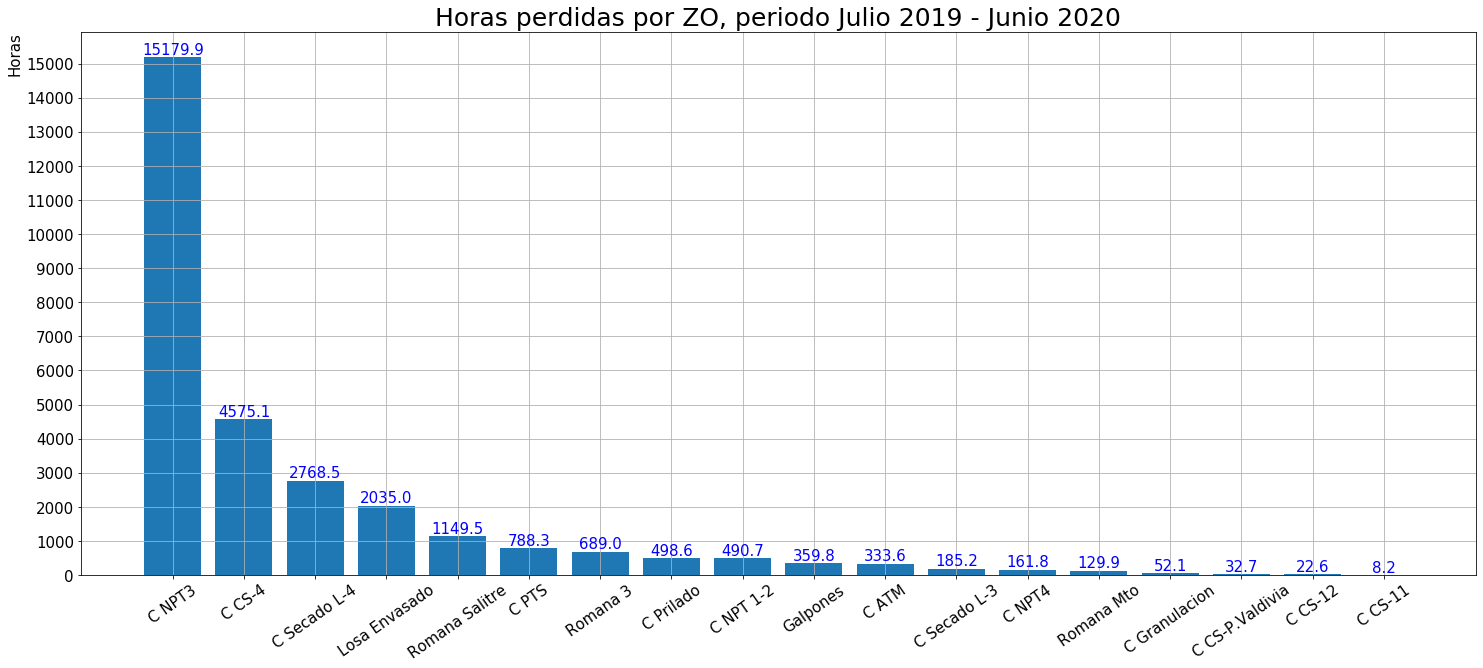

In [195]:
#HORAS PERDIDAS POR ZO
plt.figure(figsize=(25,10))
plt.bar(monetizacion_zone['Zona'],monetizacion_zone['Horas Peridas'])
plt.ylabel("Horas",position=(1,1),ha='right',fontsize=15)
plt.title("Horas perdidas por ZO, periodo Julio 2019 - Junio 2020",fontsize=25)
plt.xticks(monetizacion_zone['Zona'],fontsize=15,rotation=35)
plt.yticks(np.arange(0,15001,1000),fontsize=15)
for index, value in enumerate(monetizacion_zone['Horas Peridas']):
     plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom',position=(index,value+0.2))
plt.grid(True)
plt.savefig('./plot_finales/horas_perdidas_por_zona_2019-2020.png')
plt.show()

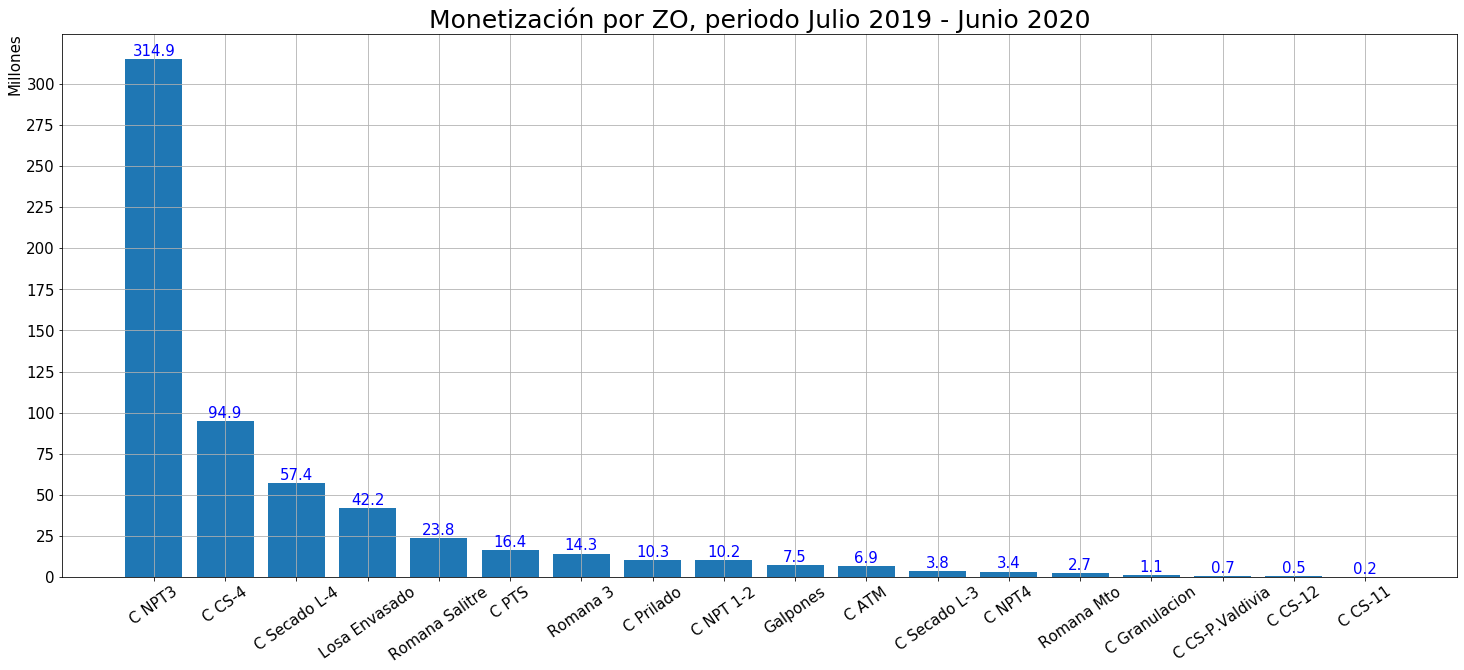

In [196]:
# COSTO POR ZO
plt.figure(figsize=(25,10))
plt.bar(monetizacion_zone['Zona'],monetizacion_zone['Valor Promedio [Millones]'])
plt.ylabel("Millones",position=(1,1),ha='right',fontsize=15)
plt.title("Monetización por ZO, periodo Julio 2019 - Junio 2020",fontsize=25)
plt.xticks(monetizacion_zone['Zona'],fontsize=15,rotation=35)
plt.yticks(np.arange(0,301,25),fontsize=15)
for index, value in enumerate(monetizacion_zone['Valor Promedio [Millones]']):
     plt.text(index,value,str(round(value,1)),fontsize=15,color='b',ha='center',va='bottom',position=(index,value+0.2))
plt.grid(True)
plt.savefig('./plot_finales/monetizacion_por_zona_2019-2020.png')
plt.show()

---
# 8-9. Horas perdidas y costo por bloque horario 

In [197]:
def monetizacion_horaria(df,df_,dia,fin=None,tiempo_ideal=None,zonas=None):
    """Entrega las horas perdidas, camiones perdidos y dinero max y min perdido para un
    determinado tiempo y zona operacional"""   
    #Parametros
    toneladas = 29.5
    price_min = 9500 
    price_max = 13000
    hr_job = 16
    if fin == None:
        fin = dia
    count = 0
    contador = 0
    for i in range(dia,fin+1): 
        prom_cola = analisis_por_dia_2(df,i,i,1,25,None,condicion='end',metric='mean',zonas=None)
        for j in zonas:
            a = stack_by_day(df_,j[0],i,i,metric='mean')
            a['minutos'] = a['minutos/camion']*a['camiones']
            print(i,j)
            #calculo de dif_time
            dif_time = pd.concat([a[['block','minutos']],prom_cola[j[0]]],axis=1)
            #print(dif_time)
            dif_time = dif_time.rename(columns={j[0]: "camiones/bloque"})
            #print(dif_time)
            dif_time["diferencia min"] = dif_time['minutos']- dif_time["camiones/bloque"]*j[1]
            dif_time.loc[dif_time['diferencia min'] < 0, 'diferencia min'] = 0   
            #concatenamos los dias
            if count == 0:
                df_aux = dif_time
                count +=1
            else:
                df_aux = df_aux + dif_time
            contador += 1
            clear_output(wait=True)

    #MONETIZACIÓN
    df_aux['block'] = df_aux['block']/contador
    horas = (df_aux['diferencia min'].sum())/60.
    camiones = horas/hr_job
    precio_minimo = (camiones * toneladas * price_min)/1000000.
    precio_maximo = (camiones * toneladas * price_max)/1000000.
    atributos = [horas,camiones,precio_minimo,precio_maximo]
    precio_promedio = (price_max+price_min)/2
    df_aux['horas'] = df_aux['diferencia min']/60.
    df_aux['camiones'] = df_aux['horas']/hr_job
    df_aux['Monetizacion [Millones]'] = (df_aux['camiones']*toneladas * precio_promedio)/1000000
    df_horarios = df_aux[['block','horas','camiones','Monetizacion [Millones]']]
    return df_horarios.rename(columns={'horas': "horas perdidas", 'camiones':'turnos camion'})

In [199]:
zonas_sort = monetizacion_zone['Zona'].tolist()
df_horario_2020 = monetizacion_horaria(colas_old,colas,1,181,zonas=pesos_zonas)
df_horario_2019 = monetizacion_horaria(colas_old,colas,182,365,zonas=pesos_zonas)
df_horario_anual = df_horario_2019 + df_horario_2020
df_horario_anual['block'] = df_horario_anual['block']/2
df_horario_anual.to_csv('./plot_finales/monetizacion_por_horario_final_v1.csv')

365 ['Romana 3', 16.6]


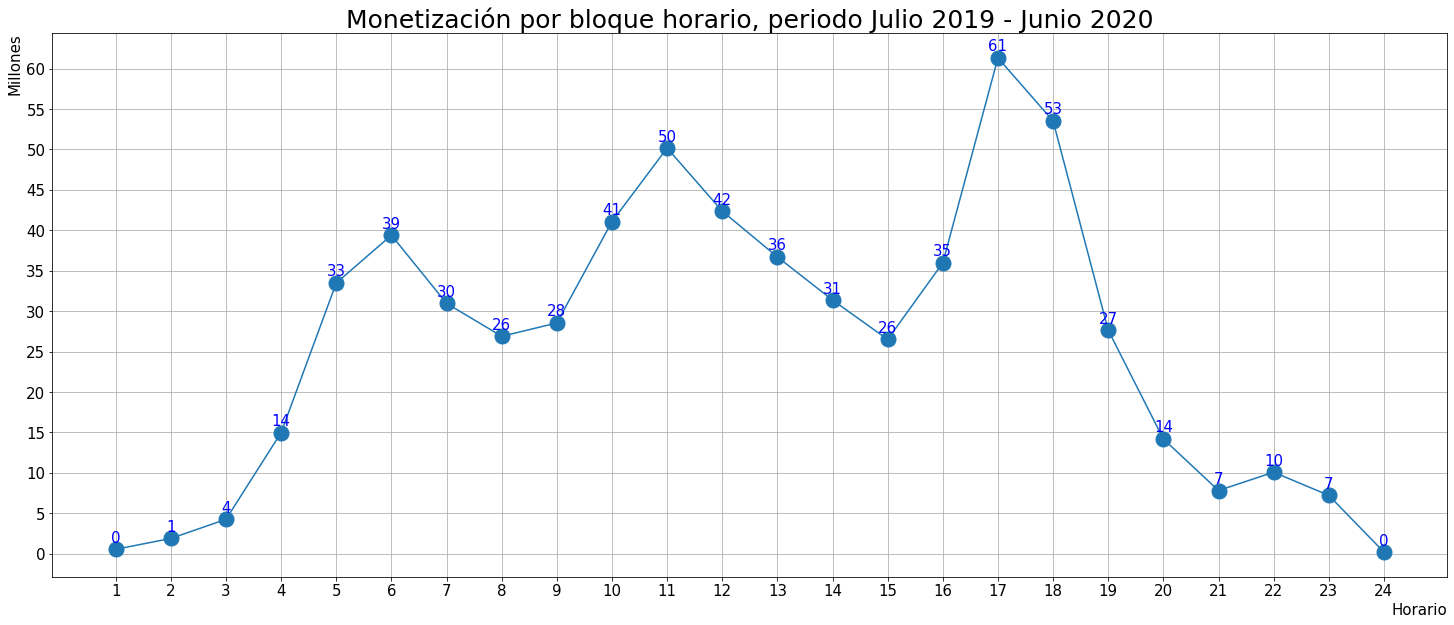

In [200]:
## horas perdidas por bloque horario
plt.figure(figsize=(25,10))
plt.plot(df_horario_anual['block'],df_horario_anual['Monetizacion [Millones]'],marker='o',markersize=15)
plt.xlabel("Horario",position=(1,1),ha='right',fontsize=15)
plt.ylabel("Millones",position=(1,1),ha='right',fontsize=15)
plt.title("Monetización por bloque horario, periodo Julio 2019 - Junio 2020",fontsize=25)
plt.xticks(df_horario_anual['block'],fontsize=15)
plt.yticks(np.arange(0,61,5),fontsize=15)
for index, value in enumerate(df_horario_anual['Monetizacion [Millones]']):
     plt.text(index+1,value,str(int(value)),fontsize=15,color='b',ha='center',va='bottom',position=(index+1,value+0.5))
plt.grid(True)
plt.savefig('./plot_finales/monetizacion_por_bloque_final_v2.png')
plt.show()

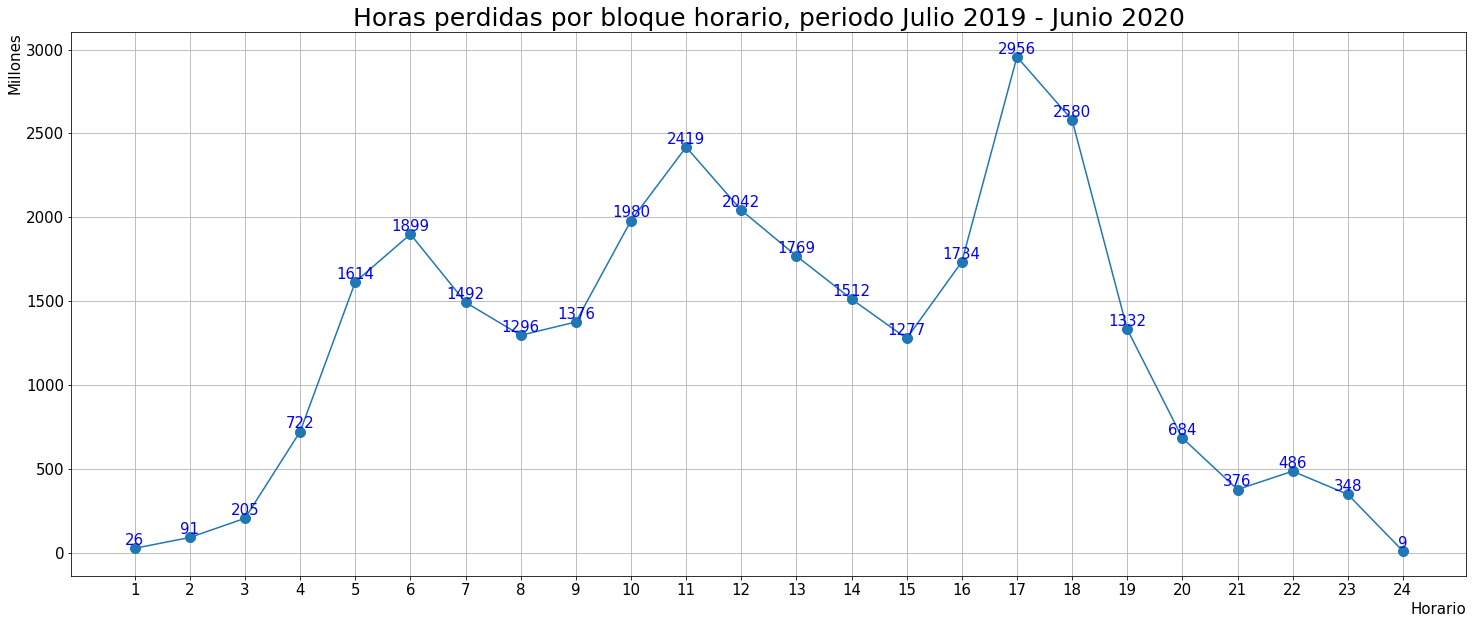

In [201]:
# horas perdidas por bloque horario
plt.figure(figsize=(25,10))
plt.plot(df_horario_anual['block'],df_horario_anual['horas perdidas'],marker='o',markersize=10)
plt.xlabel("Horario",position=(1,1),ha='right',fontsize=15)
plt.ylabel("Millones",position=(1,1),ha='right',fontsize=15)
plt.title("Horas perdidas por bloque horario, periodo Julio 2019 - Junio 2020",fontsize=25)
plt.xticks(df_horario_anual['block'],fontsize=15)
plt.yticks(np.arange(0,3001,500),fontsize=15)
for index, value in enumerate(df_horario_anual['horas perdidas']):
     plt.text(index+1,value,str(int(value)),fontsize=15,color='b',ha='center',va='bottom',position=(index+1,value+0.7))
plt.grid(True)
plt.savefig('./plot_finales/horas_perdidas_por_bloque_final_v2.png')
plt.show()

---
# 10. Nivel de actividad segun origen, destino. #6

# Los origenes destinos serian : 

1. Salar de Atacama#Coya Sur
2. Coya Sur#Tocopilla
3. Coya Sur#Cerro Dominador
4. Coya Sur#Puerto Angamos
5. Nueva Victoria#Coya Sur
6. Tocopilla#Coya Sur

In [218]:
def plotODbar(BOX, OD):
    '''
    BOX es la caja que contiene todos los datos. OD significa
    origen destino, es decir que para conseguir los graficos sera
    necesario hacer un for con esta funcion.
    
    BOX: Caja con todos los datos depurados de la tabla.
    OD: Origen Destino deseado para plotear.
    '''
    plt.figure(figsize=(15, 10))
    for Pkey in BOX[OD].keys():
        labels, counts = np.unique(BOX[OD][Pkey], return_counts=True)
        if len(counts) == 0:
            continue
        plt.bar(labels, counts, align='center')
        plt.xticks(rotation=35, fontsize=15, ha='right')
        plt.gca().set_xticks(labels)
        n1, n2 = OD.split('#')[0], OD.split('#')[1]
        n3 = str(Pkey)
        plt.title('Origen ' + n1 + ' Destino ' + n2 + ' "Producto" : ' + n3, fontsize=18)
        plt.savefig('./plot_finales/' + str(OD)+'.png')
        plt.show()
        plt.close()

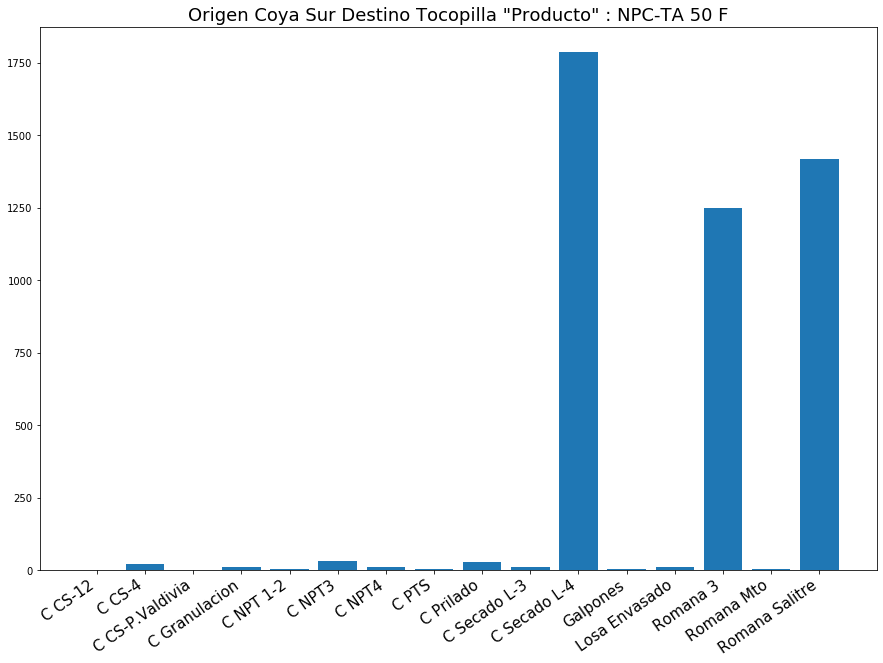

In [219]:
BOX = {}  # Las llaves seran "origin#destination"
for origin in actividad['Origin'].unique():
    for destination in actividad['Destination'].unique():
        if (destination == origin) or (destination == 'Virtual_Place') or (origin == 'Virtual_Place'):
            continue
        acti = actividad[(actividad['Origin'] == origin) & \
                        (actividad['Destination'] == destination)]
        if len(acti) == 0:
            continue
        ODkey = str(origin) + '#' + str(destination) 
        #print(ODkey)
        BOX[ODkey] = {}
        for product in acti['Product'].unique():
            if type(product) == float:
                continue
            elif (len(product.split('|')) > 1):
                continue
            acti = acti[acti['Product'] == product]
            Pkey = str(product)
            BOX[ODkey][Pkey] = acti[(acti['ZO'] != 'Salida')]['ZO'].values
plotODbar(BOX,'Coya Sur#Tocopilla')

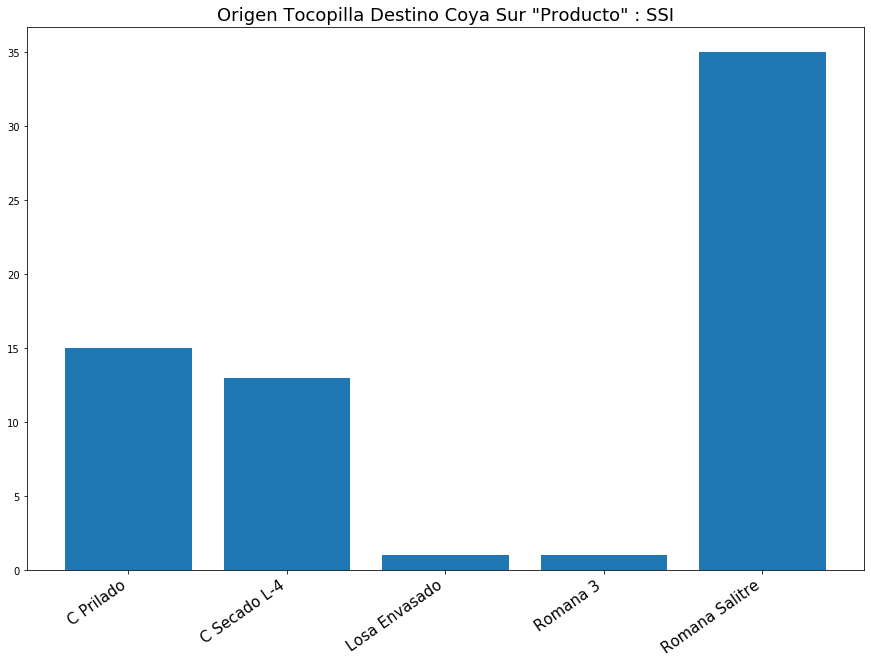

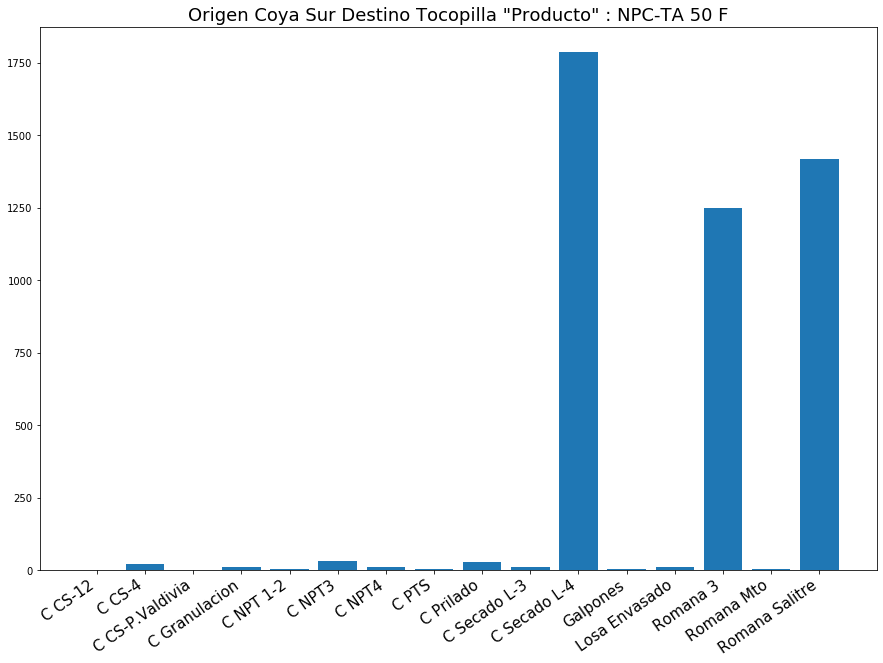

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

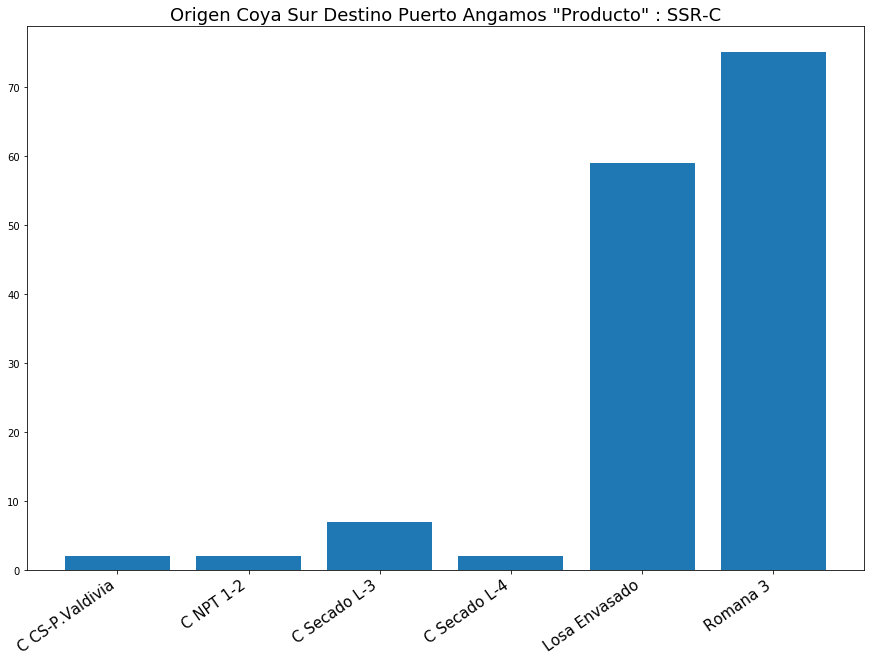

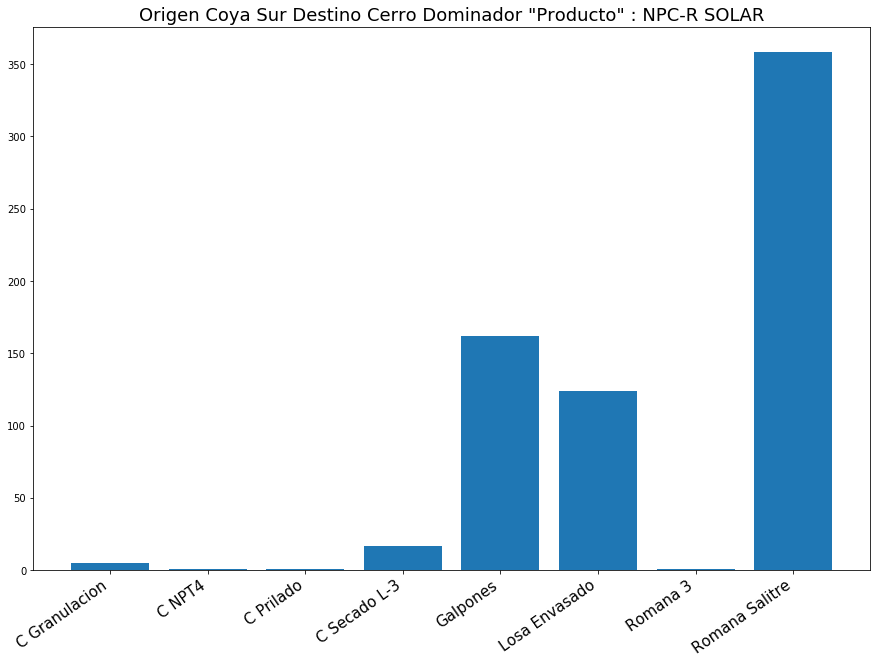

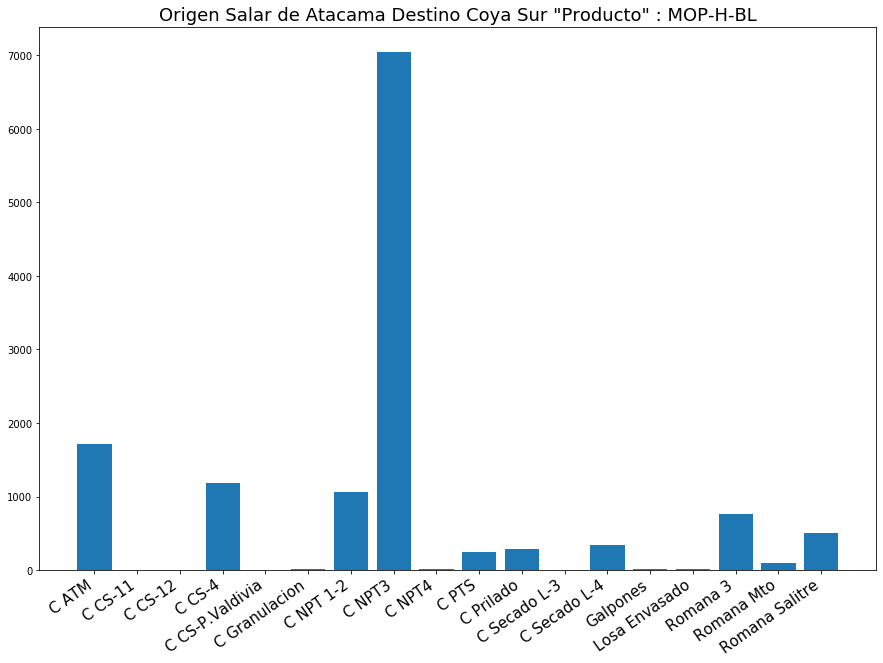

<Figure size 1080x720 with 0 Axes>

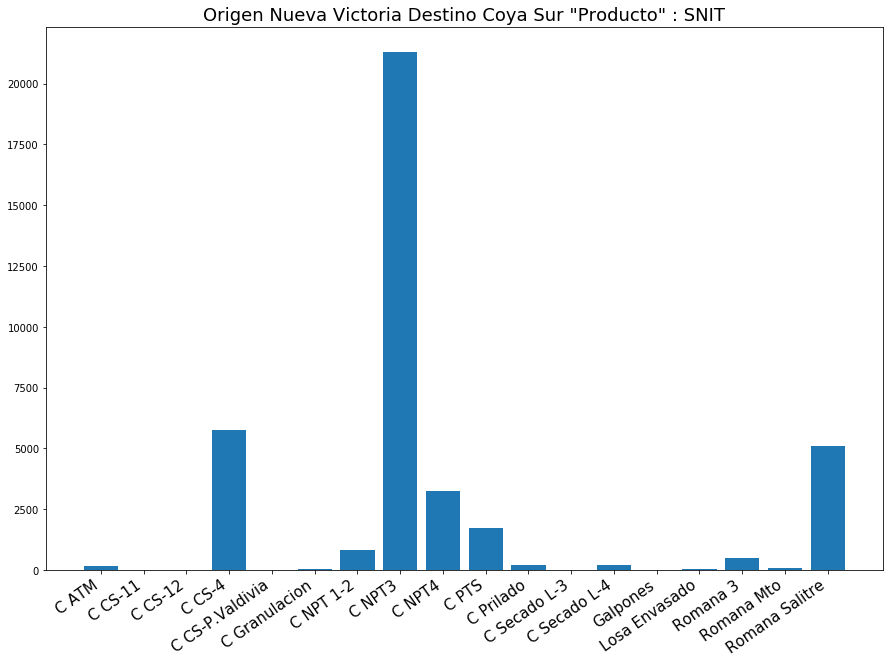

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [221]:
claves = BOX.keys()
for i in claves:
    plotODbar(BOX,i)

---
# 11. Extrapolación y costo anual 

## Extrapolación año 2020

In [225]:
año_2020 = data[(data['Mes'] == 'Enero') | (data['Mes'] == 'Febrero') | (data['Mes'] == 'Marzo') | (data['Mes'] == 'Abril') | (data['Mes'] == 'Mayo') | (data['Mes'] == 'Junio')]

print(" 6 Meses\n",año_2020.sum()[3:])

 6 Meses
 Horas Perdidas                    18715.1
Turnos Camion                      1169.7
Precio Min [Millones CLP]         327.807
Precio Max [Millones CLP]         448.579
Precio Promedio [Millones CLP]    388.193
dtype: object


In [224]:
print("Mensual \n",año_2020.sum()[3:]/6)

Mensual 
 Horas Perdidas                    3119.19
Turnos Camion                     194.949
Precio Min [Millones CLP]         54.6346
Precio Max [Millones CLP]         74.7631
Precio Promedio [Millones CLP]    64.6988
dtype: object


In [228]:
print("Año 2020 extrapolación",año_2020.sum()[3:]+(año_2020.sum()[3:]/6)*6)

Año 2020 extrapolación Horas Perdidas                    37430.3
Turnos Camion                     2339.39
Precio Min [Millones CLP]         655.615
Precio Max [Millones CLP]         897.157
Precio Promedio [Millones CLP]    776.386
dtype: object


# Calculo 2019-2020

In [227]:
año = data
print(" 12 Meses \n",año.sum()[2:])

 12 Meses 
 zona                              C Secado L-3C Secado L-3C Secado L-3C Secado L...
Horas Perdidas                                                              29460.6
Turnos Camion                                                               1841.29
Precio Min [Millones CLP]                                                   516.021
Precio Max [Millones CLP]                                                   706.134
Precio Promedio [Millones CLP]                                              611.077
dtype: object
